In [1]:
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

from sklearn.preprocessing import LabelEncoder

In [2]:
import torch
from model_common import *

In [3]:
!nvidia-smi

Tue Nov 23 05:21:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')
gpu, cpu = get_devices()

In [5]:
class MelMatrixDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelMatrixDataset(train_lbls, train_vals)
      test_data = MelMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [6]:
class MelRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
        self.final = nn.Sequential(nn.Linear(48000, 1000),nn.ReLU(), nn.Linear(1000, n_labels))
        
    def forward(self,x):
        return self.final(self.cnn(x))
    
    def __del__(self):
        self.to(cpu)

In [7]:
ragam_te_to_en = {
    'సామంతం' : 'Samantham',
    'దేసాళం' : 'Desalam',
    'రామక్రియ' : 'Ramakriya',
    'కన్నడగౌళ' : 'Kannadagowla',
    'శంకరాభరణం' : 'Sankarabharanam',
    'దేవగాంధారి' : 'Devagandhari',
    'ఆహిరి' : 'Aahiri',
    'ముఖారి' : 'Mukhari',
    'నాట' : 'Naata',
    'శుద్ధవసంతం' : 'Suddavasantham',
    'సాళంగనాట' : 'Salanganata',
    'లలిత' : 'Lalitha',
    'భూపాలం' : 'Bhupalam',
    'ధన్నాసి' : 'Dhannasi',
    'కాంబోది' : 'Kambodhi',
    'బౌళి' : 'Bauli',
    'గుండుక్రియ' : 'Gundukriya',
    'శ్రీరాగం' : 'Sriragam',
    'భైరవి' : 'Bhairavi',
    'పాడి' : 'Paadi',
    'మాళవి' : 'Maalavi',
    'నాదరామక్రియ' : 'Nadaramakriya',
    'మలహరి' : 'Malahari',
    'వరాళి' : 'Varali',
    'గౌళ' : 'Gowla',
    'సాళంగం' : 'Salangam',
    'బౌళిరామక్రియ' : 'Bauliramakriya',
    'మాళవిగౌళ' : 'Malavigowla',
    'గుజ్జరి' : 'Gujjari',
    'దేసాక్షి' : 'Desakshi'
}

In [8]:
data['Ragam'].replace(ragam_te_to_en,inplace=True)

In [13]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2, nindex_factor=3):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    
    np.random.seed(42)
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    pindex = ndata[ndata[target]==1].index
    nindex = ndata[ndata[target]==0].index
    index = np.random.choice(pindex,pindex.shape[0]).tolist() + np.random.choice(nindex,nindex_factor*pindex.shape[0]).tolist()
    tdata = ndata.loc[index]
    
    results[i] = train_model(tdata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : f'{title} - {lbl}',
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Aahiri'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 216/54
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.207 / Validation Loss : 11.931 [Time Taken : 1.278756 seconds]
Epoch 2/15 : Training Loss: 10.942 / Validation Loss : 11.325 [Time Taken : 1.310163 seconds]
Epoch 3/15 : Training Loss: 9.801 / Validation Loss : 8.626 [Time Taken : 1.268654 seconds]
Epoch 4/15 : Training Loss: 6.921 / Validation Loss : 4.525 [Time Taken : 1.289182 seconds]
Epoch 5/15 : Training Loss: 2.789 / Validation Loss : 0.920 [Time Taken : 1.292855 seconds]
Epoch 6/15 : Training Loss: 0.857 / Validation Loss : 1.291 [Time Taken : 0.852767 seconds]
Epoch 7/15 : Training Loss: 0.115 / Validation Loss : 2.884 [Time Taken : 0.819813 seconds]
Epoch 8/15 : Training Loss: 0.486 / Validation Loss : 2.511 [Time Taken : 0.829299 seconds]
Epoch 9/15 : Training Loss: 0.245 / Validation Loss : 1.782 [Time Taken : 0.822207 seconds]
Epoch 10/15 : Training Loss: 0.076 / Validation Loss

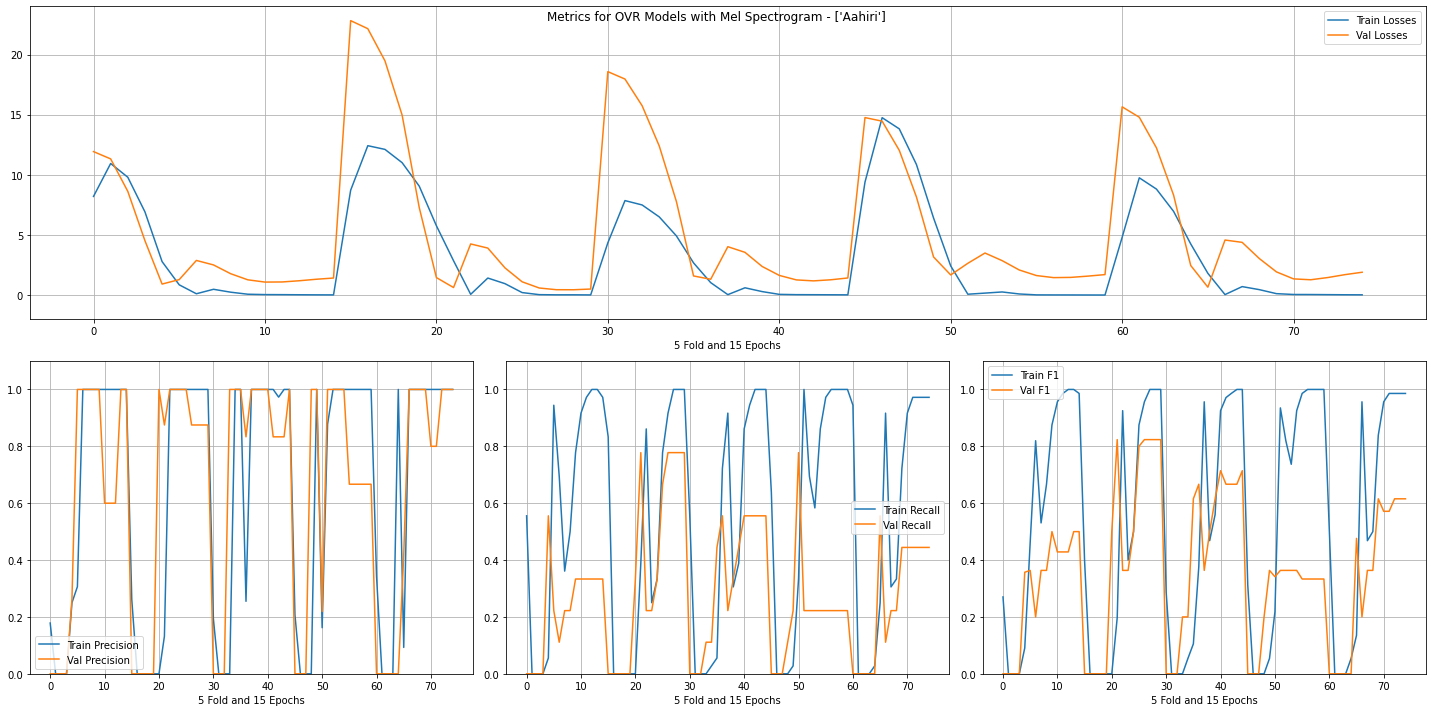

    train_f1  validation_f1  ...  train_losses  validation_losses
12  1.000000       0.823529  ...      0.026220           0.451356
13  1.000000       0.823529  ...      0.027850           0.447760
14  1.000000       0.823529  ...      0.018814           0.506451
11  0.956522       0.823529  ...      0.040341           0.592893
6   0.197183       0.823529  ...      2.861657           0.632829
..       ...            ...  ...           ...                ...
1   0.000000       0.000000  ...     14.750908          14.460632
2   0.000000       0.000000  ...     13.821165          12.036248
1   0.000000       0.000000  ...      9.752492          14.788121
2   0.000000       0.000000  ...      8.815224          12.243134
3   0.000000       0.000000  ...      6.963164           8.314089

[75 rows x 12 columns]
Training for ['Bauli'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.737 / Validation Loss : 11.026 [Time Ta

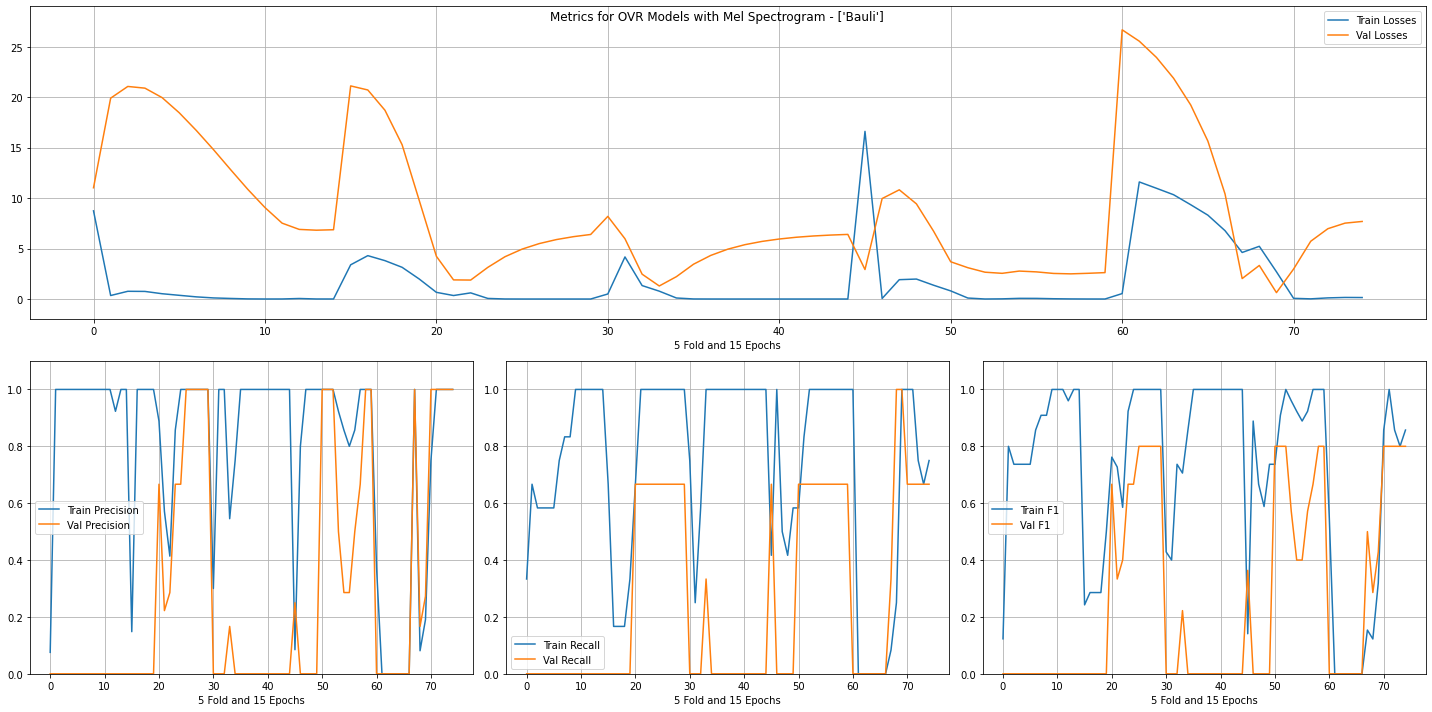

    train_f1  validation_f1  ...  train_losses  validation_losses
10       1.0            0.8  ...      0.000320           4.945598
11       1.0            0.8  ...      0.000102           5.494230
12       1.0            0.8  ...      0.000022           5.891274
13       1.0            0.8  ...      0.000015           6.180577
14       1.0            0.8  ...      0.000007           6.397572
..       ...            ...  ...           ...                ...
2        0.0            0.0  ...     10.975492          23.944311
3        0.0            0.0  ...     10.335714          21.880062
4        0.0            0.0  ...      9.343385          19.229107
5        0.0            0.0  ...      8.310254          15.650362
6        0.0            0.0  ...      6.774840          10.419161

[75 rows x 12 columns]
Training for ['Bauliramakriya'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 91/23
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 11.506 / Validation Loss : 1.738

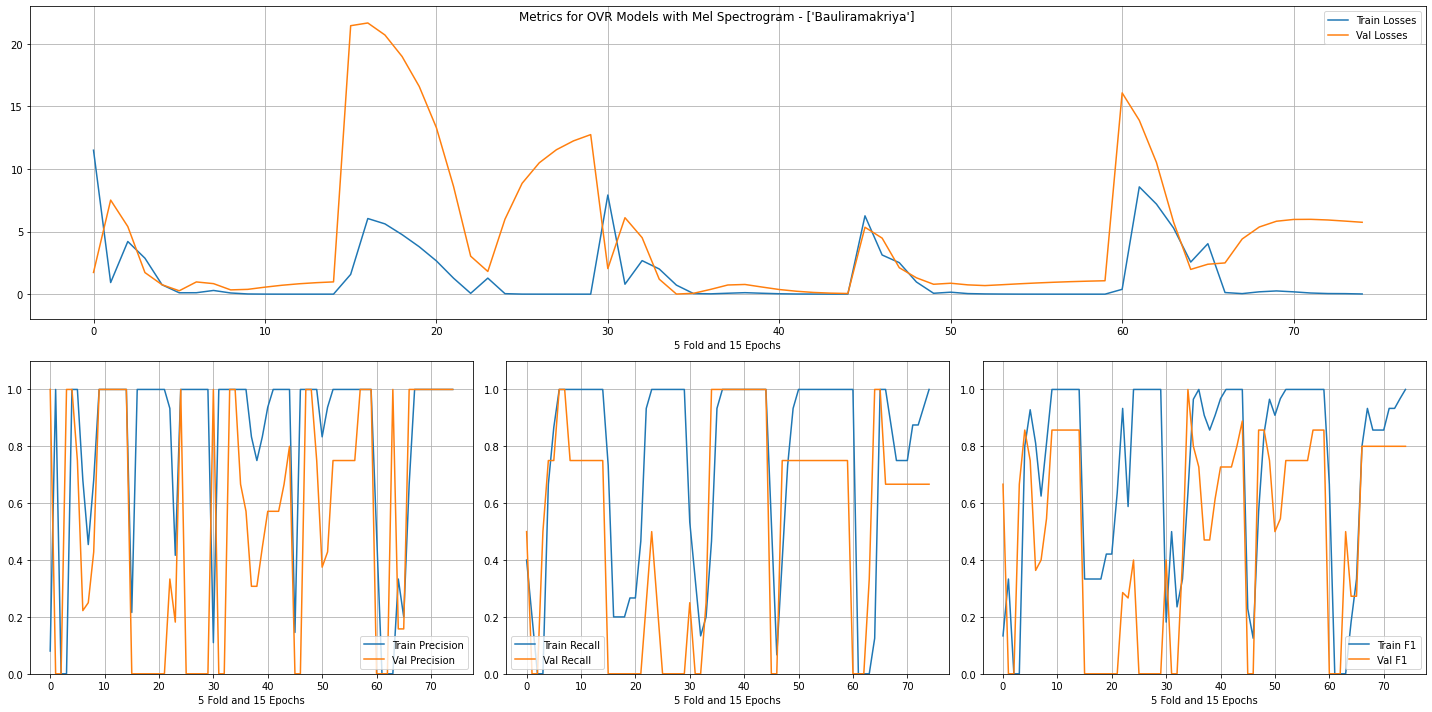

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.636364       1.000000  ...      0.723642           0.009134
14  1.000000       0.888889  ...      0.002674           0.054085
9   1.000000       0.857143  ...      0.017108           0.384967
10  1.000000       0.857143  ...      0.005717           0.561256
11  1.000000       0.857143  ...      0.002621           0.714366
..       ...            ...  ...           ...                ...
0   0.228571       0.000000  ...      6.262391           5.349252
1   0.125000       0.000000  ...      3.131342           4.479710
2   0.000000       0.000000  ...      4.209907           5.405391
1   0.000000       0.000000  ...      8.574722          13.896394
2   0.000000       0.000000  ...      7.201817          10.530333

[75 rows x 12 columns]
Training for ['Bhairavi'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 134/34
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.028 / Validation Loss : 9.750 [Time

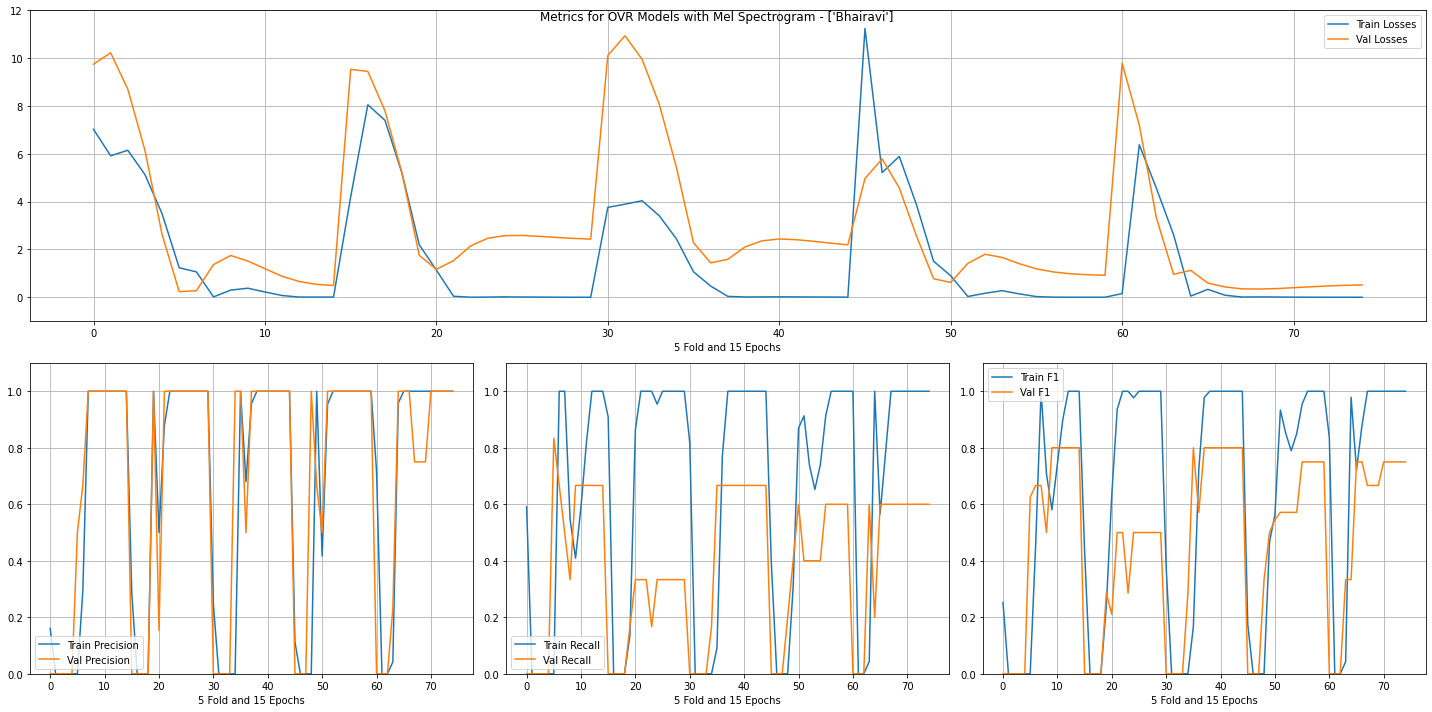

    train_f1  validation_f1  ...  train_losses  validation_losses
12       1.0            0.8  ...      0.009983           0.660997
13       1.0            0.8  ...      0.008598           0.541305
14       1.0            0.8  ...      0.009277           0.490183
8        1.0            0.8  ...      0.012067           2.105048
9        1.0            0.8  ...      0.015733           2.363148
..       ...            ...  ...           ...                ...
3        0.0            0.0  ...      3.409945           8.072206
1        0.0            0.0  ...      5.216092           5.789800
2        0.0            0.0  ...      5.890603           4.573370
1        0.0            0.0  ...      6.380125           7.203043
2        0.0            0.0  ...      4.556044           3.315199

[75 rows x 12 columns]
Training for ['Bhupalam'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.754 / Validation Loss : 11.392 [Time

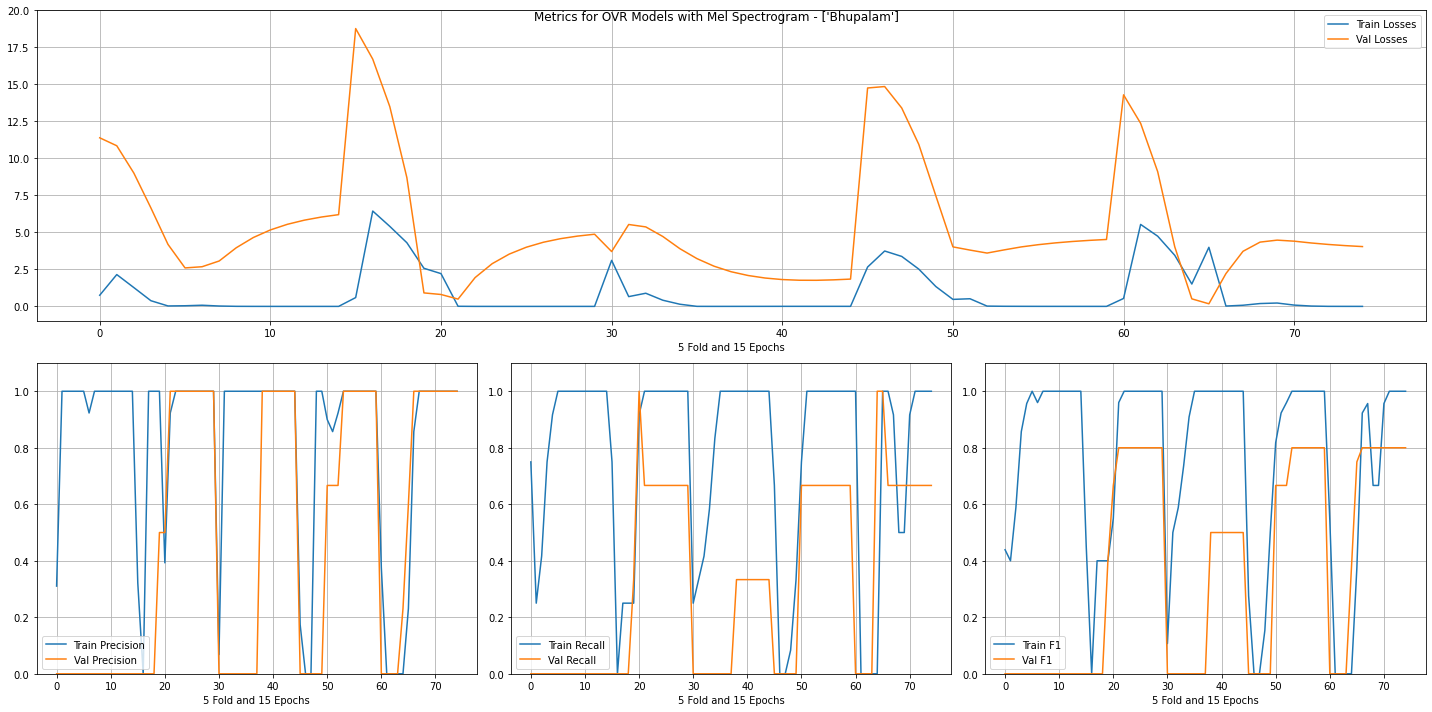

    train_f1  validation_f1  ...  train_losses  validation_losses
7        1.0            0.8  ...      0.000655           1.948767
8        1.0            0.8  ...      0.000159           2.886976
9        1.0            0.8  ...      0.000082           3.534485
10       1.0            0.8  ...      0.000093           3.998317
11       1.0            0.8  ...      0.000154           4.334760
..       ...            ...  ...           ...                ...
1        0.0            0.0  ...      3.742748          14.855498
2        0.0            0.0  ...      3.377037          13.405294
1        0.0            0.0  ...      5.539028          12.370918
2        0.0            0.0  ...      4.744195           9.102526
3        0.0            0.0  ...      3.452141           4.026507

[75 rows x 12 columns]
Training for ['Desakshi'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 67/17
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 3.815 / Validation Loss : 10.049 [Time

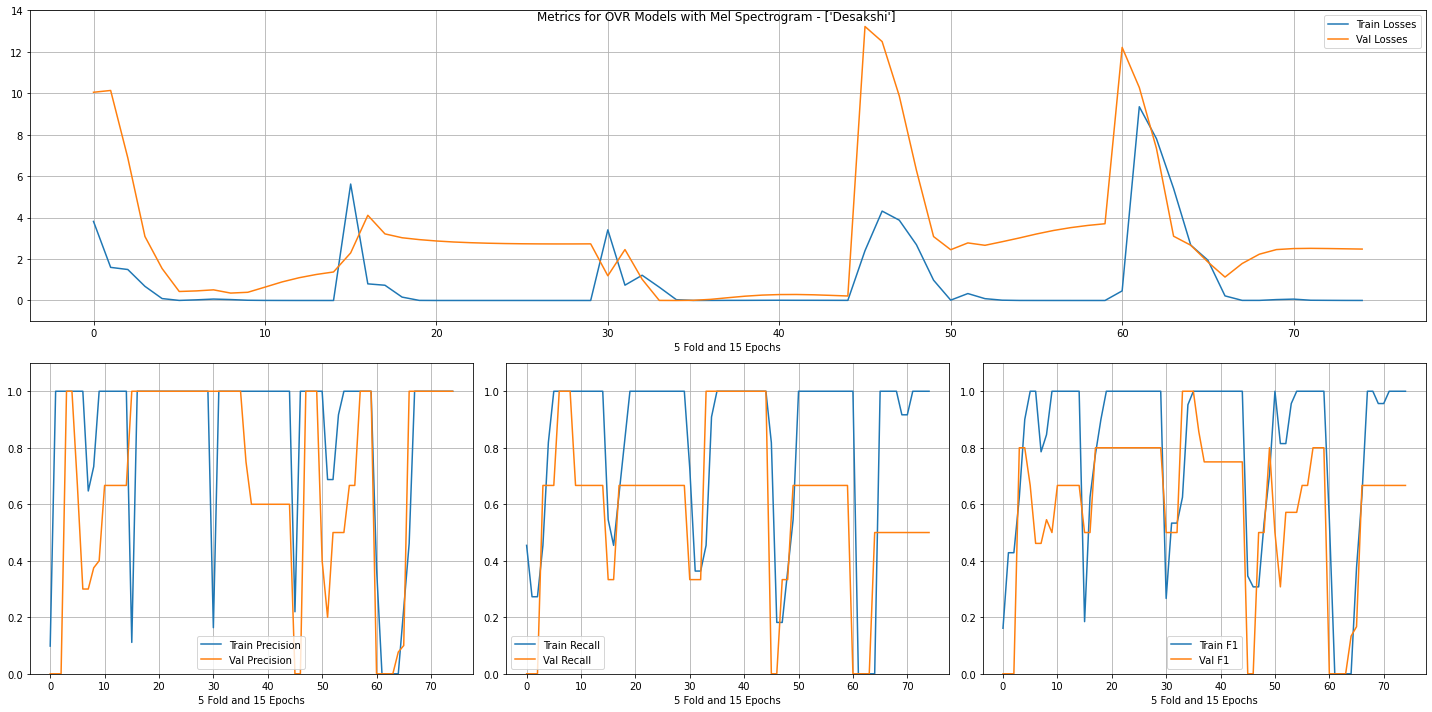

    train_f1  validation_f1  ...  train_losses  validation_losses
5   1.000000       1.000000  ...      0.001709           0.007629
4   0.952381       1.000000  ...      0.036402           0.000287
3   0.625000       1.000000  ...      0.642683           0.002761
6   1.000000       0.857143  ...      0.003423           0.054454
4   1.000000       0.800000  ...      0.003935           2.937673
..       ...            ...  ...           ...                ...
1   0.307692       0.000000  ...      4.313934          12.494376
0   0.161290       0.000000  ...      3.814667          10.049204
1   0.000000       0.000000  ...      9.350468          10.280284
2   0.000000       0.000000  ...      7.810143           7.340162
3   0.000000       0.000000  ...      5.405356           3.101130

[75 rows x 12 columns]
Training for ['Desalam'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 168/42
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.925 / Validation Loss : 14.843 [Time

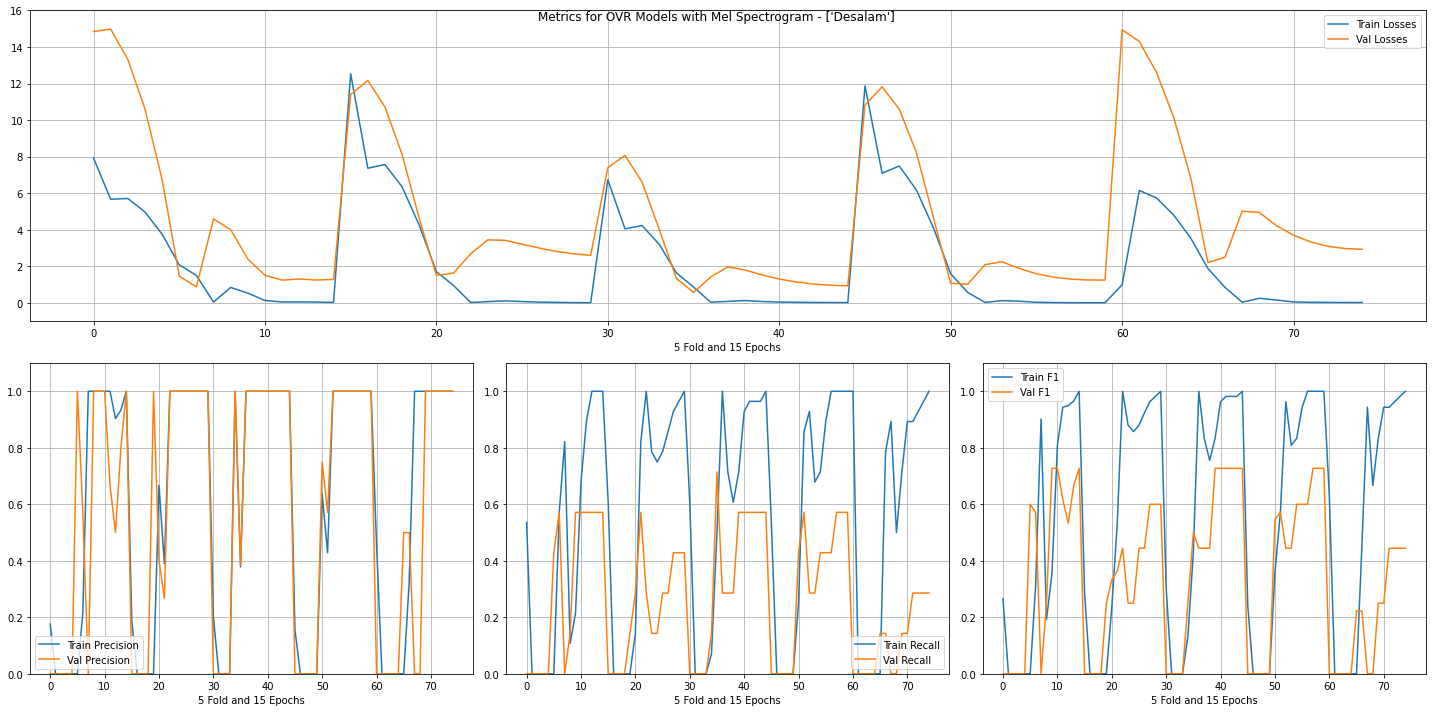

    train_f1  validation_f1  ...  train_losses  validation_losses
14       1.0       0.727273  ...      0.026602           1.285910
14       1.0       0.727273  ...      0.019338           0.935133
12       1.0       0.727273  ...      0.012629           1.299451
13       1.0       0.727273  ...      0.011189           1.254218
14       1.0       0.727273  ...      0.009303           1.247832
..       ...            ...  ...           ...                ...
4        0.0       0.000000  ...      4.092783           4.643987
1        0.0       0.000000  ...      6.151453          14.302561
2        0.0       0.000000  ...      5.744413          12.608827
3        0.0       0.000000  ...      4.812906          10.167654
4        0.0       0.000000  ...      3.543771           6.839838

[75 rows x 12 columns]
Training for ['Devagandhari'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 139/35
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.746 / Validation Loss : 7.815 [

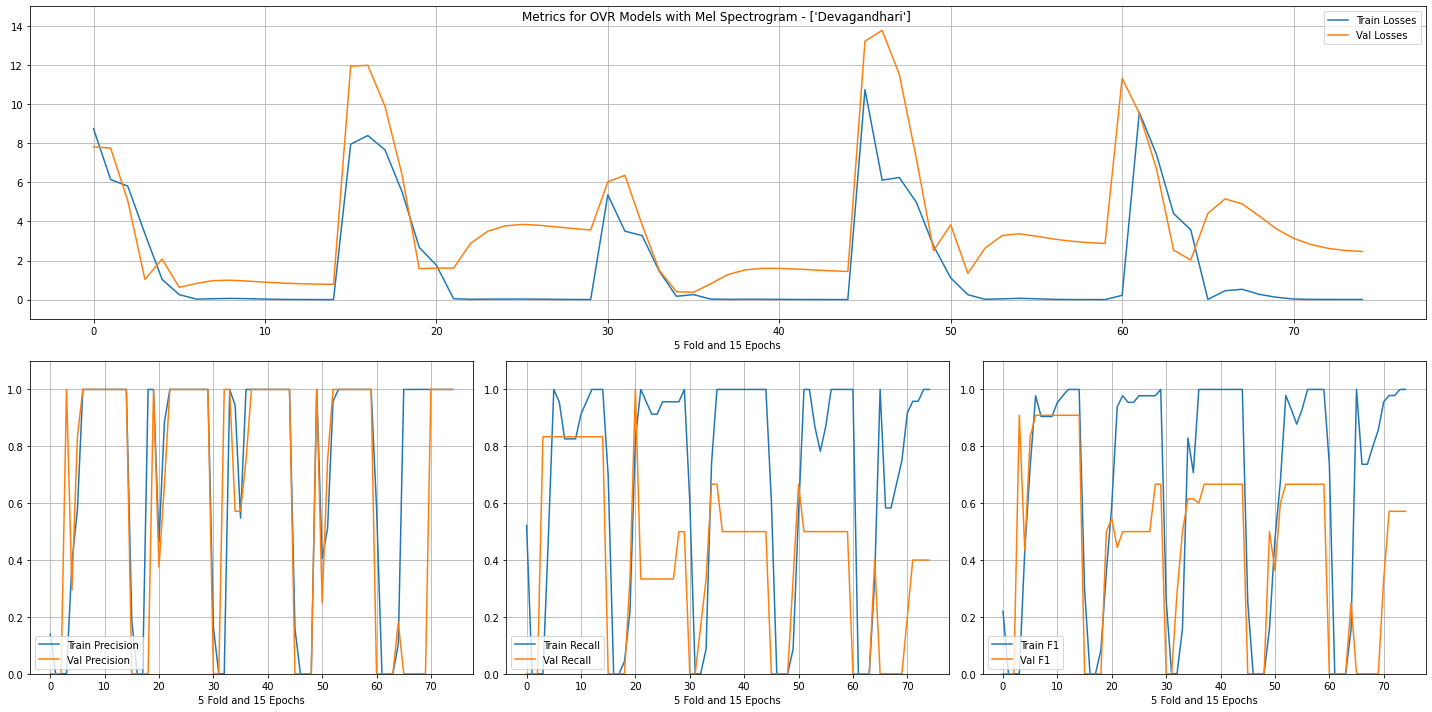

    train_f1  validation_f1  ...  train_losses  validation_losses
12  1.000000       0.909091  ...      0.007644           0.816824
13  1.000000       0.909091  ...      0.004718           0.795758
14  1.000000       0.909091  ...      0.004145           0.783720
6   0.977778       0.909091  ...      0.027938           0.830294
11  0.977778       0.909091  ...      0.013538           0.849433
..       ...            ...  ...           ...                ...
2   0.000000       0.000000  ...      6.248679          11.529406
3   0.000000       0.000000  ...      4.972947           7.196532
1   0.000000       0.000000  ...      9.585614           9.534302
2   0.000000       0.000000  ...      7.431341           6.699235
3   0.000000       0.000000  ...      4.404459           2.533954

[75 rows x 12 columns]
Training for ['Dhannasi'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 192/48
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.451 / Validation Loss : 11.210 [Ti

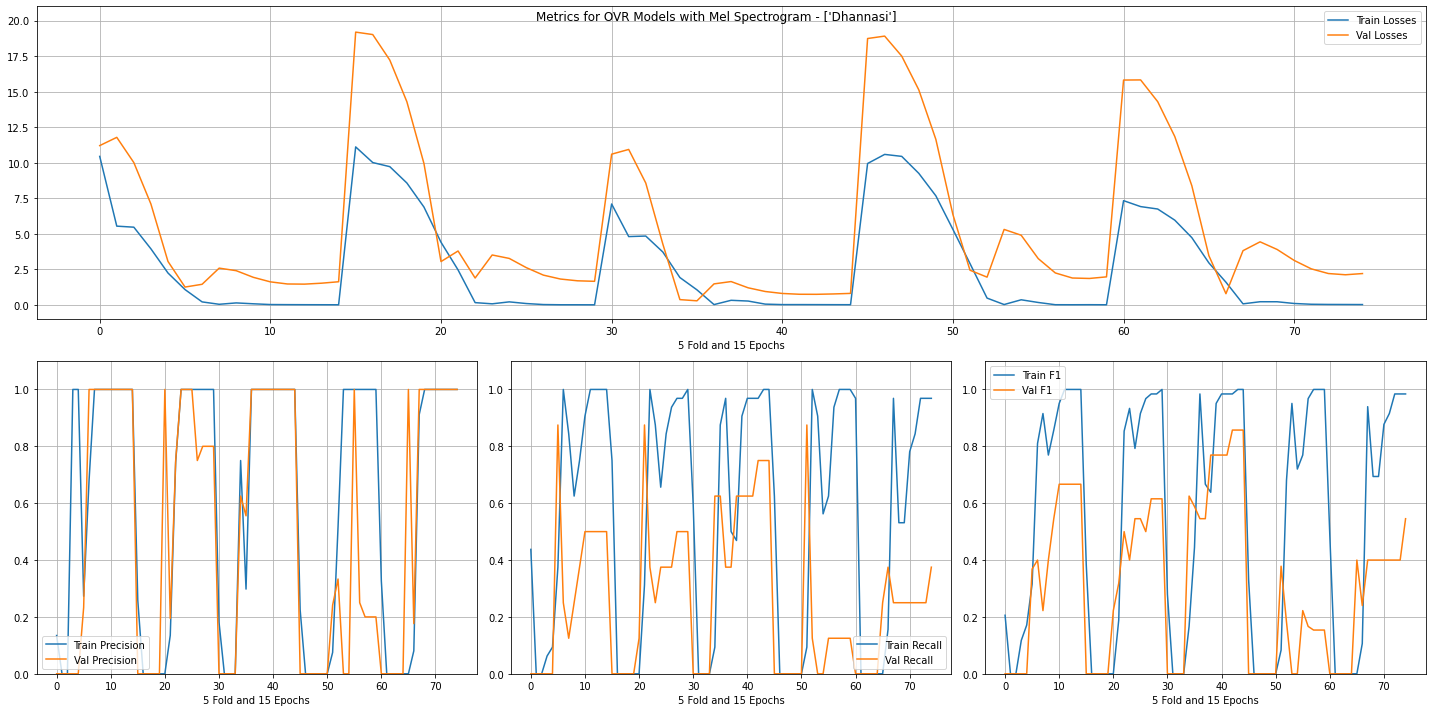

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.857143  ...      0.021597           0.776229
14  1.000000       0.857143  ...      0.019558           0.814693
12  0.984127       0.857143  ...      0.025222           0.750236
10  0.984127       0.769231  ...      0.027203           0.810282
11  0.984127       0.769231  ...      0.027473           0.754064
..       ...            ...  ...           ...                ...
5   0.000000       0.000000  ...      5.314900           6.356867
1   0.000000       0.000000  ...      6.919868          15.828698
2   0.000000       0.000000  ...      6.749716          14.300390
3   0.000000       0.000000  ...      5.966845          11.851902
4   0.000000       0.000000  ...      4.737023           8.387745

[75 rows x 12 columns]
Training for ['Gowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 2.011 / Validation Loss : 8.950 [Time Tak

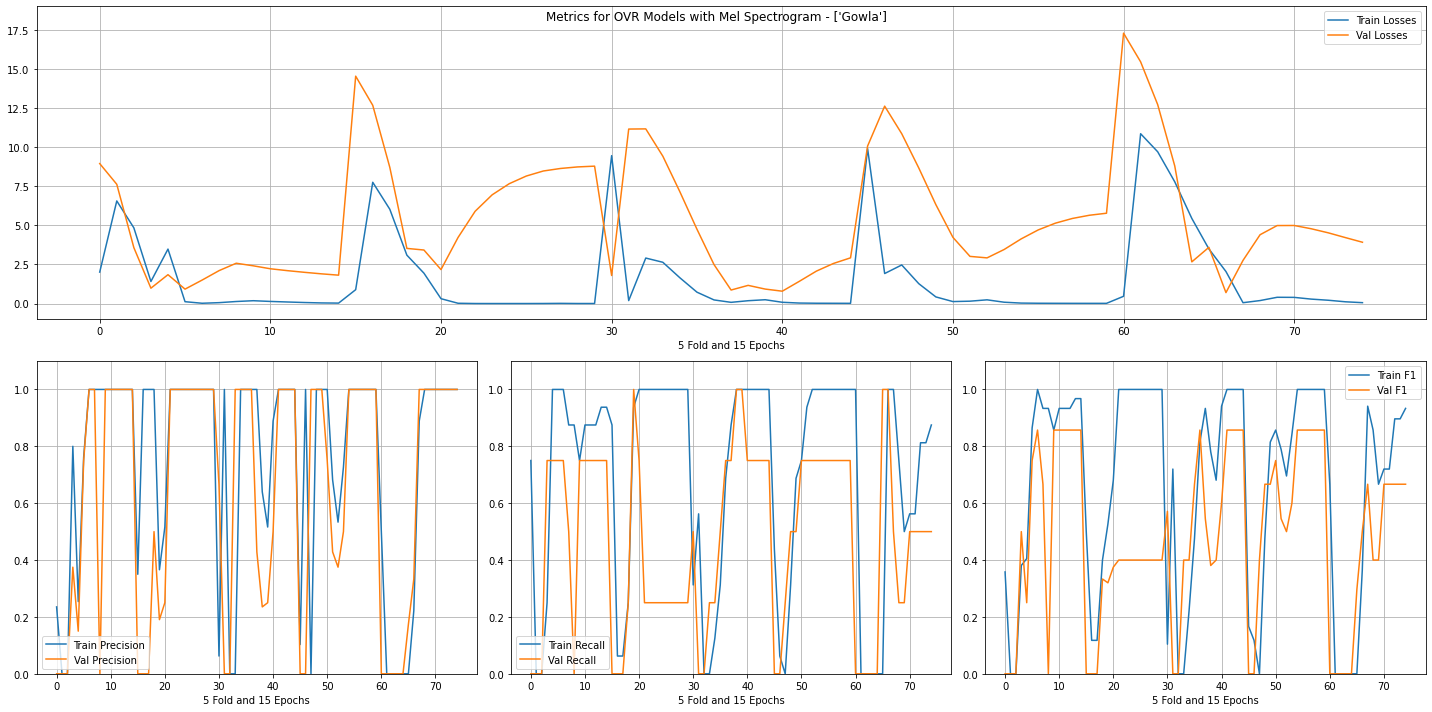

    train_f1  validation_f1  ...  train_losses  validation_losses
6        1.0       0.857143  ...      0.019371           1.501239
11       1.0       0.857143  ...      0.032395           1.422189
12       1.0       0.857143  ...      0.020640           2.074687
13       1.0       0.857143  ...      0.018086           2.564304
14       1.0       0.857143  ...      0.014839           2.923844
..       ...            ...  ...           ...                ...
2        0.0       0.000000  ...      2.909593          11.168377
1        0.0       0.000000  ...     10.858479          15.454744
2        0.0       0.000000  ...      9.704874          12.720486
3        0.0       0.000000  ...      7.784989           8.797061
4        0.0       0.000000  ...      5.443252           2.666404

[75 rows x 12 columns]
Training for ['Gujjari'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 120/30
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.288 / Validation Loss : 13.948 [Time

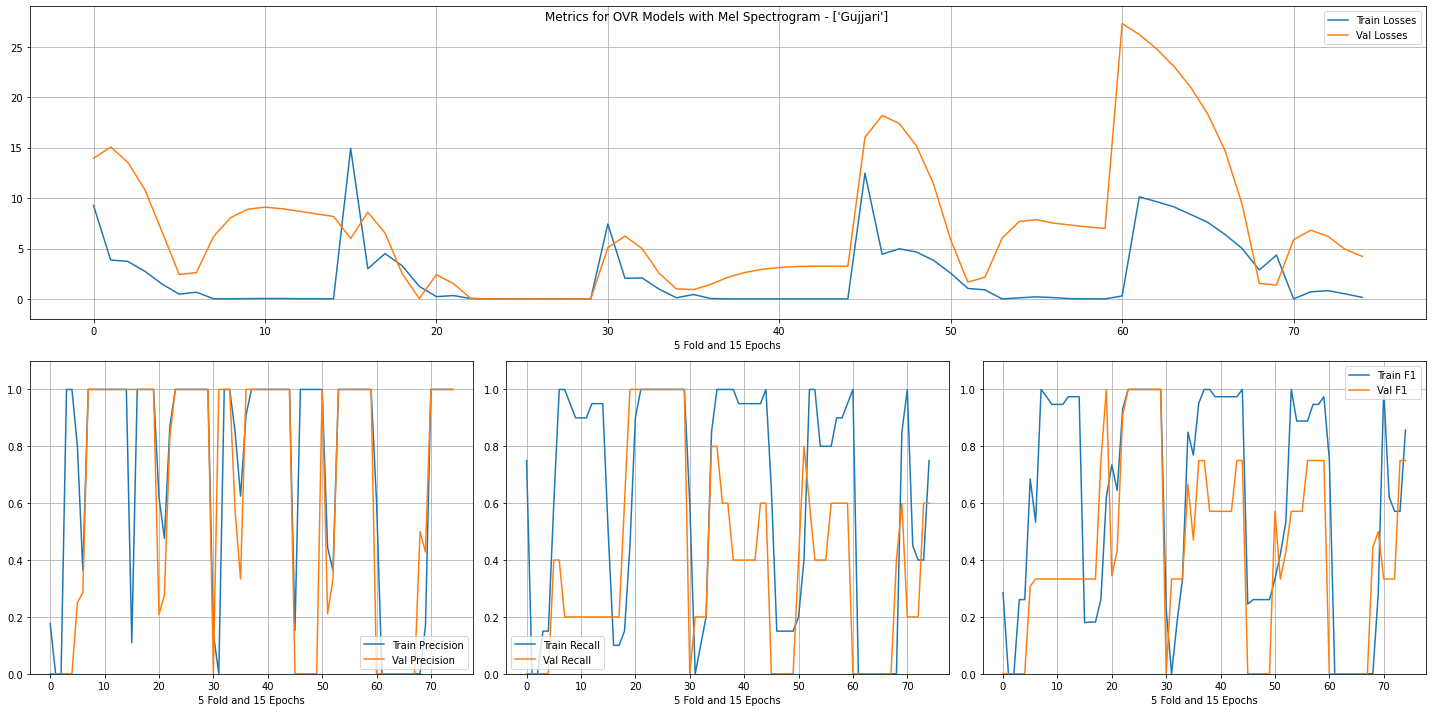

    train_f1  validation_f1  ...  train_losses  validation_losses
8        1.0            1.0  ...      0.014222           0.007531
9        1.0            1.0  ...      0.011440           0.004409
10       1.0            1.0  ...      0.011936           0.003323
11       1.0            1.0  ...      0.012504           0.002863
12       1.0            1.0  ...      0.010834           0.002673
..       ...            ...  ...           ...                ...
3        0.0            0.0  ...      9.146544          23.096483
4        0.0            0.0  ...      8.381858          20.985464
5        0.0            0.0  ...      7.591338          18.312620
6        0.0            0.0  ...      6.394903          14.710378
7        0.0            0.0  ...      5.011938           9.375883

[75 rows x 12 columns]
Training for ['Gundukriya'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.651 / Validation Loss : 4.779 [Tim

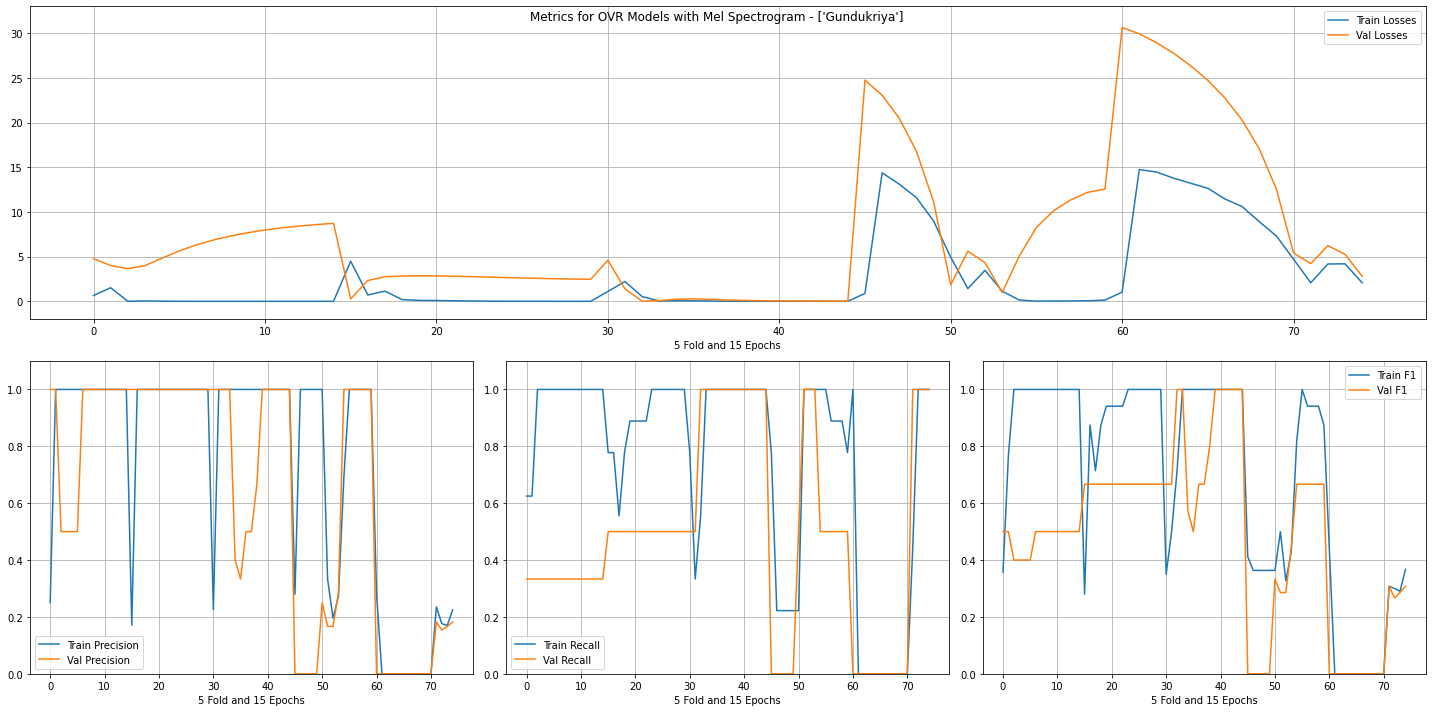

    train_f1  validation_f1  ...  train_losses  validation_losses
3        1.0            1.0  ...      0.036433           0.081248
9        1.0            1.0  ...      0.004424           0.064342
10       1.0            1.0  ...      0.003496           0.043420
11       1.0            1.0  ...      0.002819           0.031480
12       1.0            1.0  ...      0.002387           0.024535
..       ...            ...  ...           ...                ...
6        0.0            0.0  ...     11.449786          22.743492
7        0.0            0.0  ...     10.598696          20.272322
8        0.0            0.0  ...      8.915673          17.057865
9        0.0            0.0  ...      7.304258          12.531689
10       0.0            0.0  ...      4.711303           5.406424

[75 rows x 12 columns]
Training for ['Kambodhi'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 235/59
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.364 / Validation Loss : 15.906 [Tim

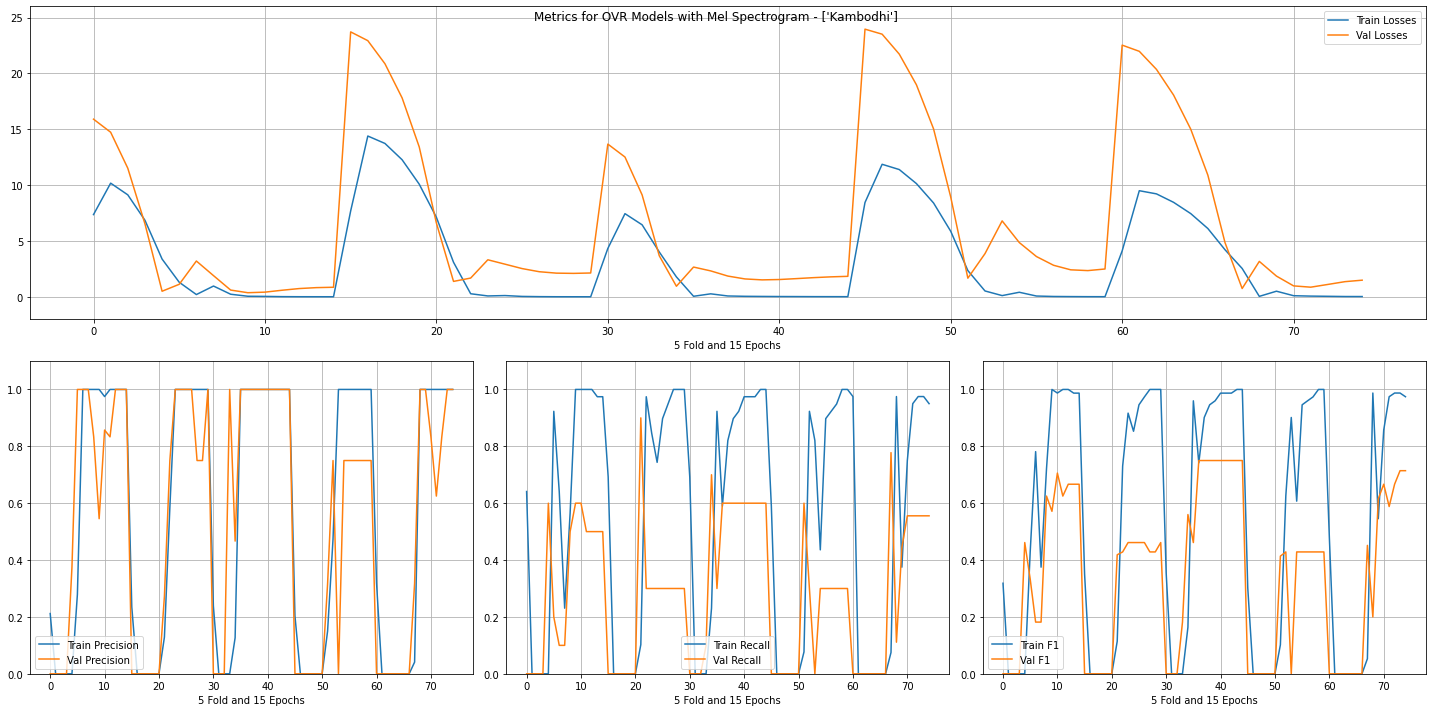

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000           0.75  ...      0.018123           1.789889
14  1.000000           0.75  ...      0.015836           1.837341
10  0.987013           0.75  ...      0.029474           1.551299
11  0.987013           0.75  ...      0.025429           1.632985
12  0.987013           0.75  ...      0.020193           1.719793
..       ...            ...  ...           ...                ...
2   0.000000           0.00  ...      9.218998          20.365173
3   0.000000           0.00  ...      8.461769          18.062721
4   0.000000           0.00  ...      7.453552          15.012095
5   0.000000           0.00  ...      6.115599          10.891832
6   0.000000           0.00  ...      4.216178           4.853573

[75 rows x 12 columns]
Training for ['Kannadagowla'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 336/84
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.166 / Validation Loss : 15.003

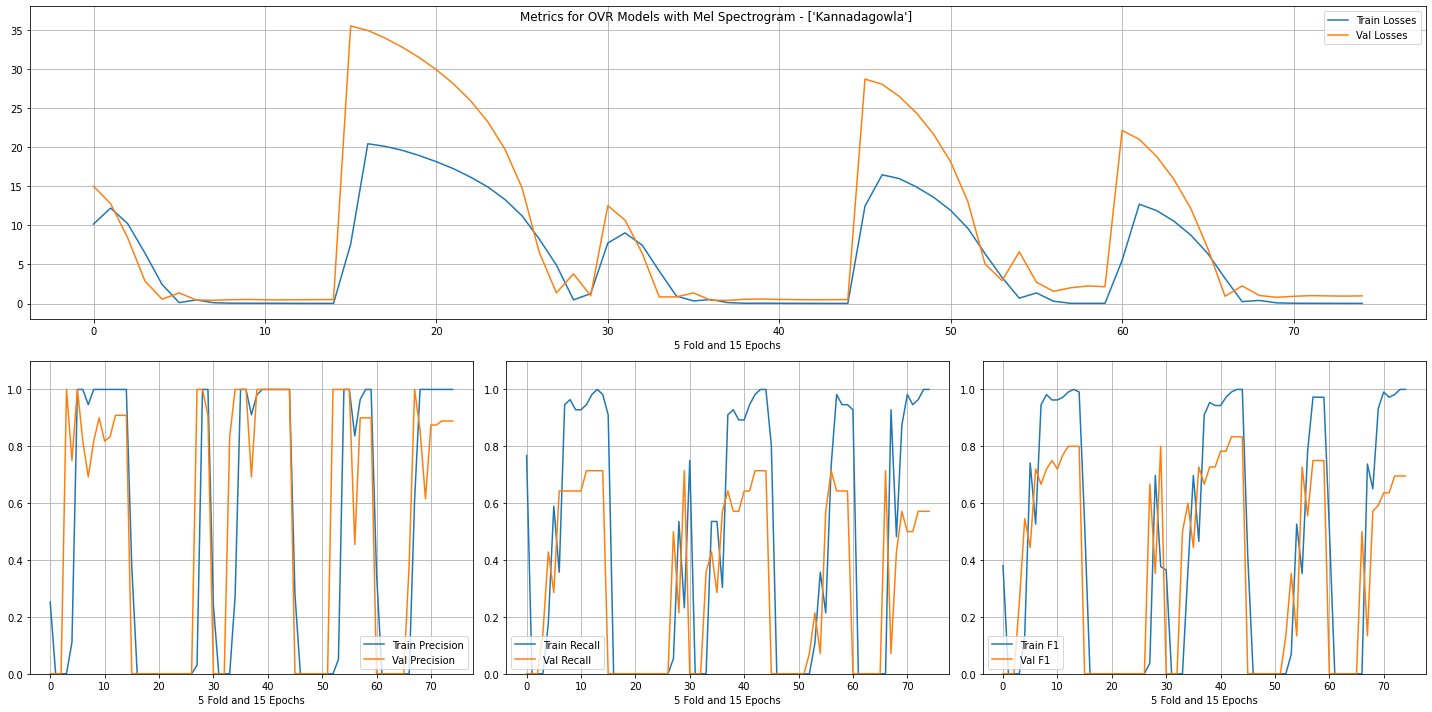

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.833333  ...      0.021037           0.493558
14  1.000000       0.833333  ...      0.017883           0.506430
12  0.990991       0.833333  ...      0.024783           0.488778
13  1.000000       0.800000  ...      0.023210           0.500866
12  0.990991       0.800000  ...      0.027243           0.485960
..       ...            ...  ...           ...                ...
1   0.000000       0.000000  ...     12.706197          20.994859
2   0.000000       0.000000  ...     11.898875          18.839278
3   0.000000       0.000000  ...     10.566209          15.945134
4   0.000000       0.000000  ...      8.765711          12.172359
5   0.000000       0.000000  ...      6.382839           7.029793

[75 rows x 12 columns]
Training for ['Lalitha'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 62/16
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 11.066 / Validation Loss : 0.953 [Time 

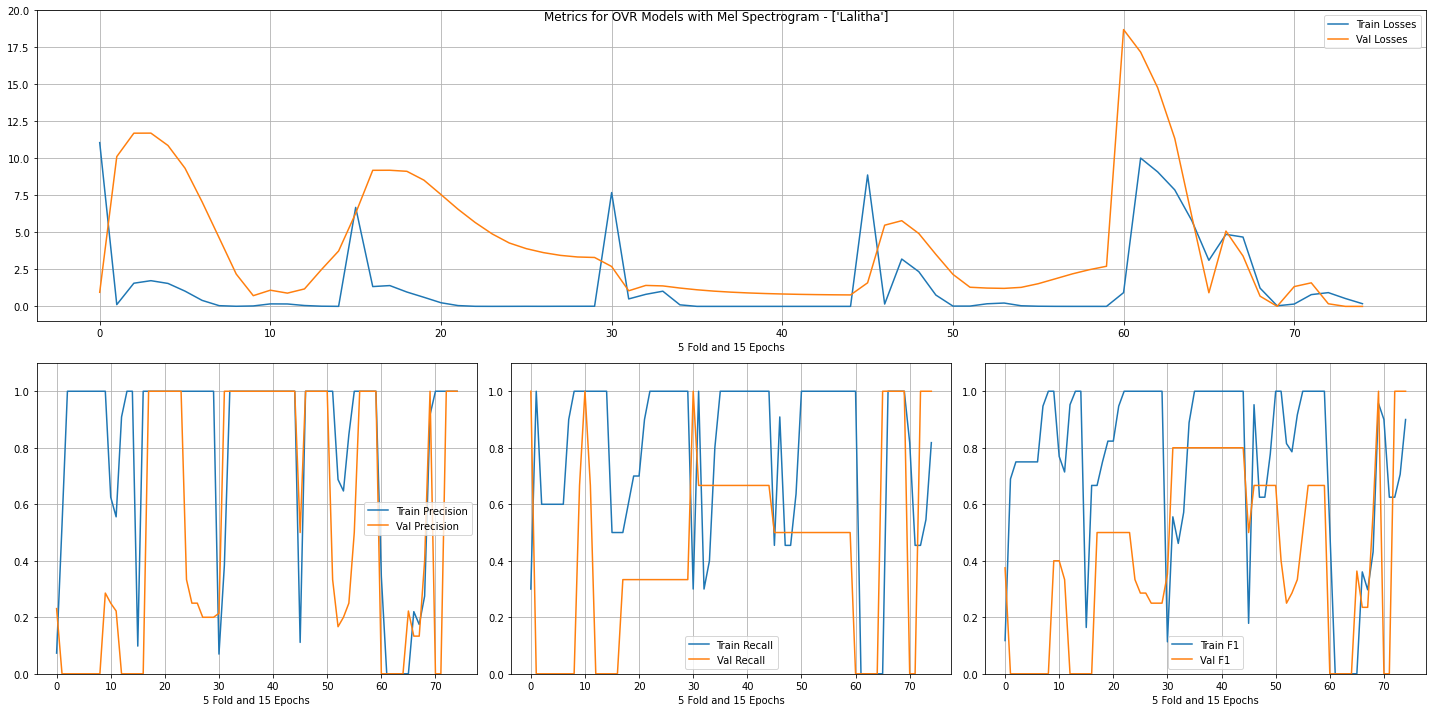

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.956522            1.0  ...      0.041058           0.004812
14  0.900000            1.0  ...      0.182412           0.000414
13  0.705882            1.0  ...      0.532554           0.000475
12  0.625000            1.0  ...      0.930876           0.176623
5   1.000000            0.8  ...      0.001800           1.122746
..       ...            ...  ...           ...                ...
0   0.163934            0.0  ...      6.689427           6.295513
1   0.000000            0.0  ...     10.021053          17.181650
2   0.000000            0.0  ...      9.086780          14.770894
3   0.000000            0.0  ...      7.872032          11.348197
4   0.000000            0.0  ...      5.795524           6.080872

[75 rows x 12 columns]
Training for ['Maalavi'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 153/39
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.951 / Validation Loss : 7.737 [Time 

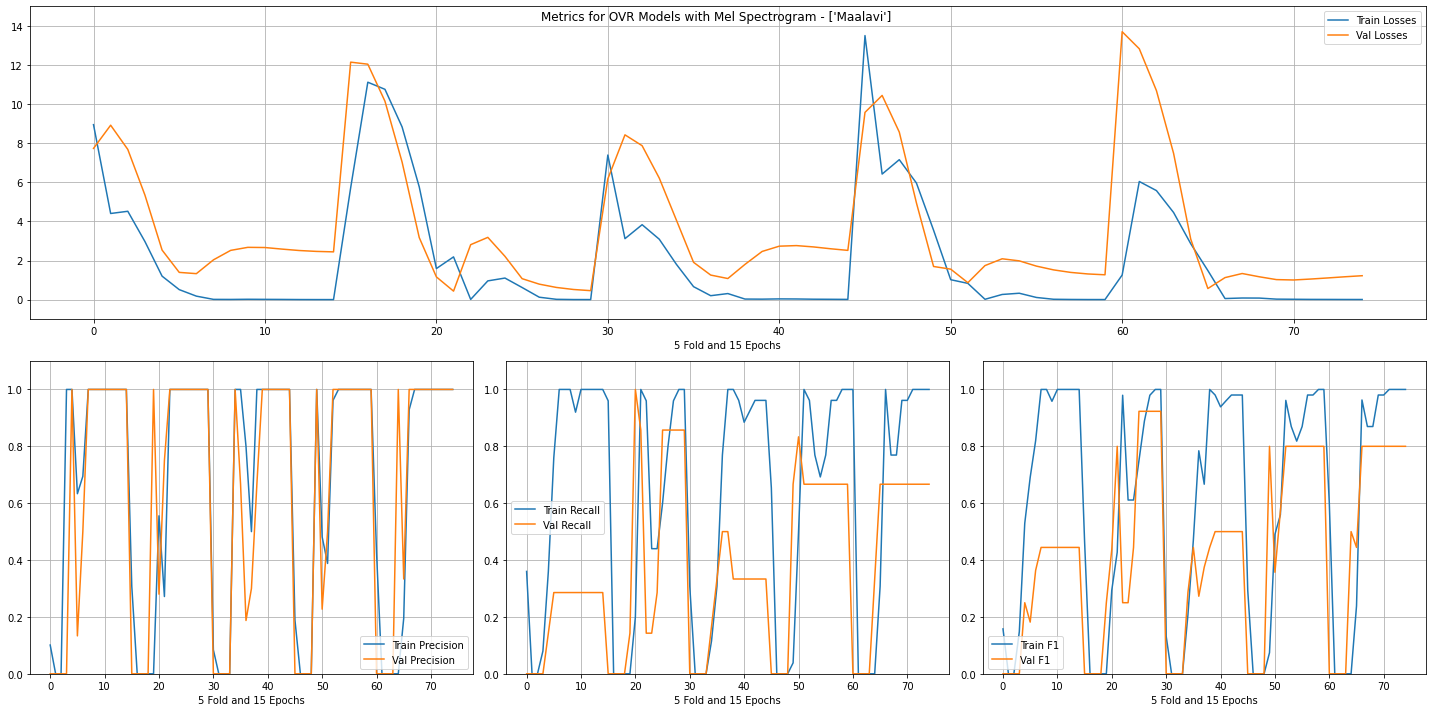

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.923077  ...      0.005448           0.519650
14  1.000000       0.923077  ...      0.004131           0.459830
12  0.979592       0.923077  ...      0.016898           0.624356
11  0.888889       0.923077  ...      0.124758           0.793266
10  0.750000       0.923077  ...      0.621055           1.073630
..       ...            ...  ...           ...                ...
2   0.000000       0.000000  ...      7.159766           8.571281
3   0.000000       0.000000  ...      5.965053           4.950776
1   0.000000       0.000000  ...      6.043098          12.831833
2   0.000000       0.000000  ...      5.577968          10.692126
3   0.000000       0.000000  ...      4.457432           7.482544

[75 rows x 12 columns]
Training for ['Malahari'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 129/33
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.984 / Validation Loss : 9.719 [Time

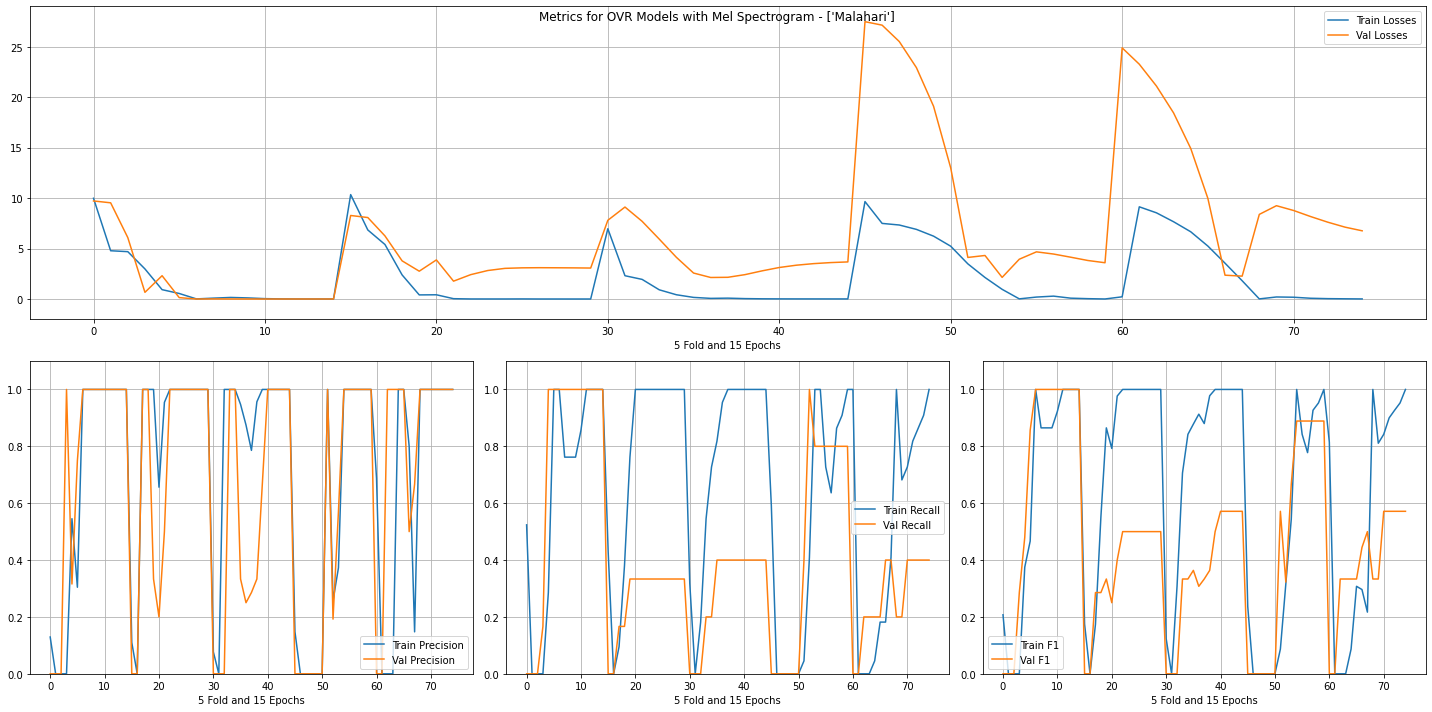

    train_f1  validation_f1  ...  train_losses  validation_losses
6        1.0            1.0  ...      0.012131           0.000989
11       1.0            1.0  ...      0.012134           0.000783
12       1.0            1.0  ...      0.004322           0.001052
13       1.0            1.0  ...      0.002151           0.001271
14       1.0            1.0  ...      0.001946           0.001424
..       ...            ...  ...           ...                ...
2        0.0            0.0  ...      7.335225          25.515678
3        0.0            0.0  ...      6.901375          22.930456
4        0.0            0.0  ...      6.230203          19.100597
5        0.0            0.0  ...      5.233503          12.993328
1        0.0            0.0  ...      9.137518          23.270016

[75 rows x 12 columns]
Training for ['Malavigowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 18.576 / Validation Loss : 2.031 [T

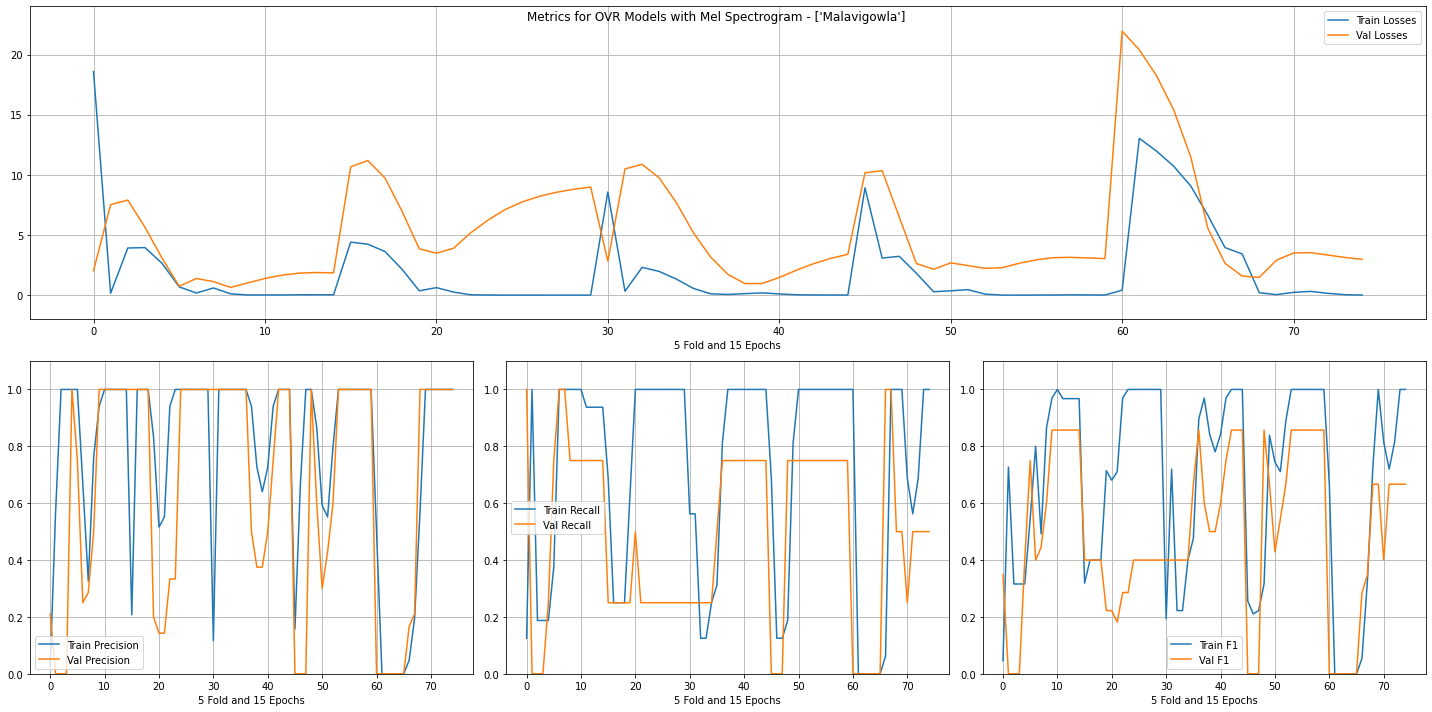

    train_f1  validation_f1  ...  train_losses  validation_losses
10       1.0       0.857143  ...      0.013360           1.384784
12       1.0       0.857143  ...      0.014385           2.613629
13       1.0       0.857143  ...      0.009443           3.054584
14       1.0       0.857143  ...      0.007361           3.391794
8        1.0       0.857143  ...      0.003379           2.282010
..       ...            ...  ...           ...                ...
1        0.0       0.000000  ...     13.028201          20.393881
2        0.0       0.000000  ...     11.977234          18.251316
3        0.0       0.000000  ...     10.727511          15.424515
4        0.0       0.000000  ...      9.072030          11.495785
5        0.0       0.000000  ...      6.632995           5.550510

[75 rows x 12 columns]
Training for ['Mukhari'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 7.659 / Validation Loss : 9.877 [Time T

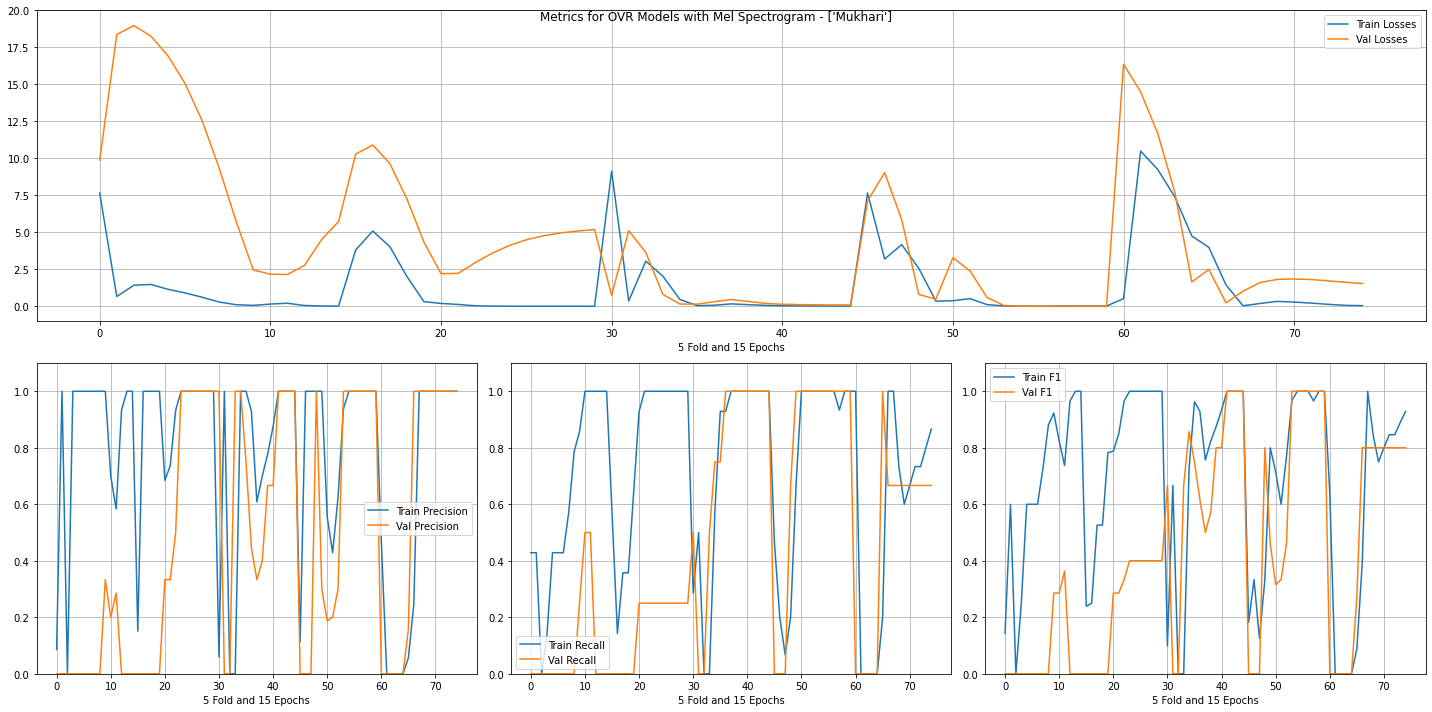

    train_f1  validation_f1  ...  train_losses  validation_losses
11       1.0            1.0  ...      0.030788           0.120552
12       1.0            1.0  ...      0.024431           0.107721
13       1.0            1.0  ...      0.021308           0.099706
14       1.0            1.0  ...      0.019320           0.093914
9        1.0            1.0  ...      0.016709           0.011285
..       ...            ...  ...           ...                ...
2        0.0            0.0  ...      3.057368           3.648655
1        0.0            0.0  ...     10.493204          14.496495
2        0.0            0.0  ...      9.255718          11.699184
3        0.0            0.0  ...      7.407211           7.721814
4        0.0            0.0  ...      4.757172           1.650367

[75 rows x 12 columns]
Training for ['Naata'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.200 / Validation Loss : 5.354 [Time Ta

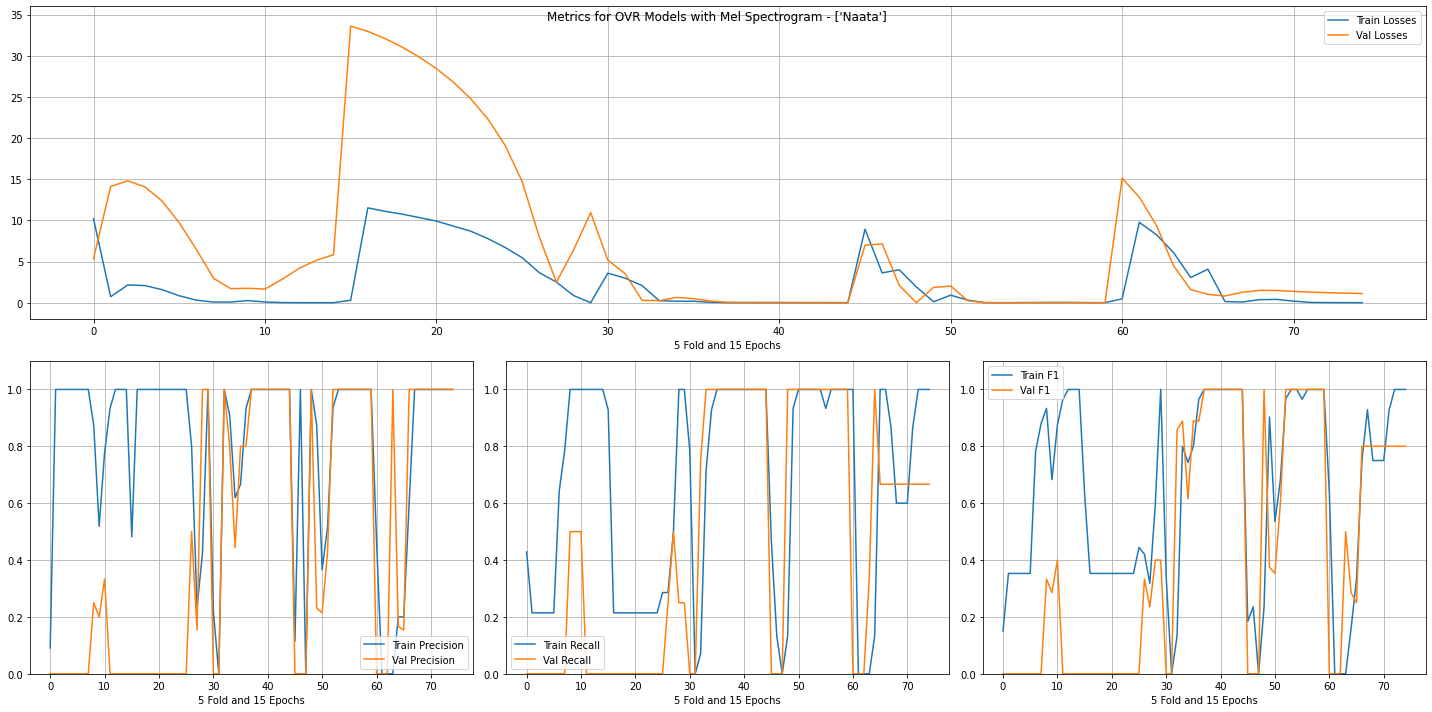

    train_f1  validation_f1  ...  train_losses  validation_losses
7       1.00            1.0  ...      0.016030           0.046608
8       1.00            1.0  ...      0.009462           0.039031
9       1.00            1.0  ...      0.007494           0.035253
10      1.00            1.0  ...      0.006877           0.031417
11      1.00            1.0  ...      0.005880           0.027556
..       ...            ...  ...           ...                ...
0       0.15            0.0  ...     10.200225           5.354424
1       0.00            0.0  ...      2.992946           3.546876
2       0.00            0.0  ...      4.005315           2.102099
1       0.00            0.0  ...      9.770168          12.824163
2       0.00            0.0  ...      8.265455           9.391487

[75 rows x 12 columns]
Training for ['Nadaramakriya'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 264/66
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 6.232 / Validation Loss : 16.208

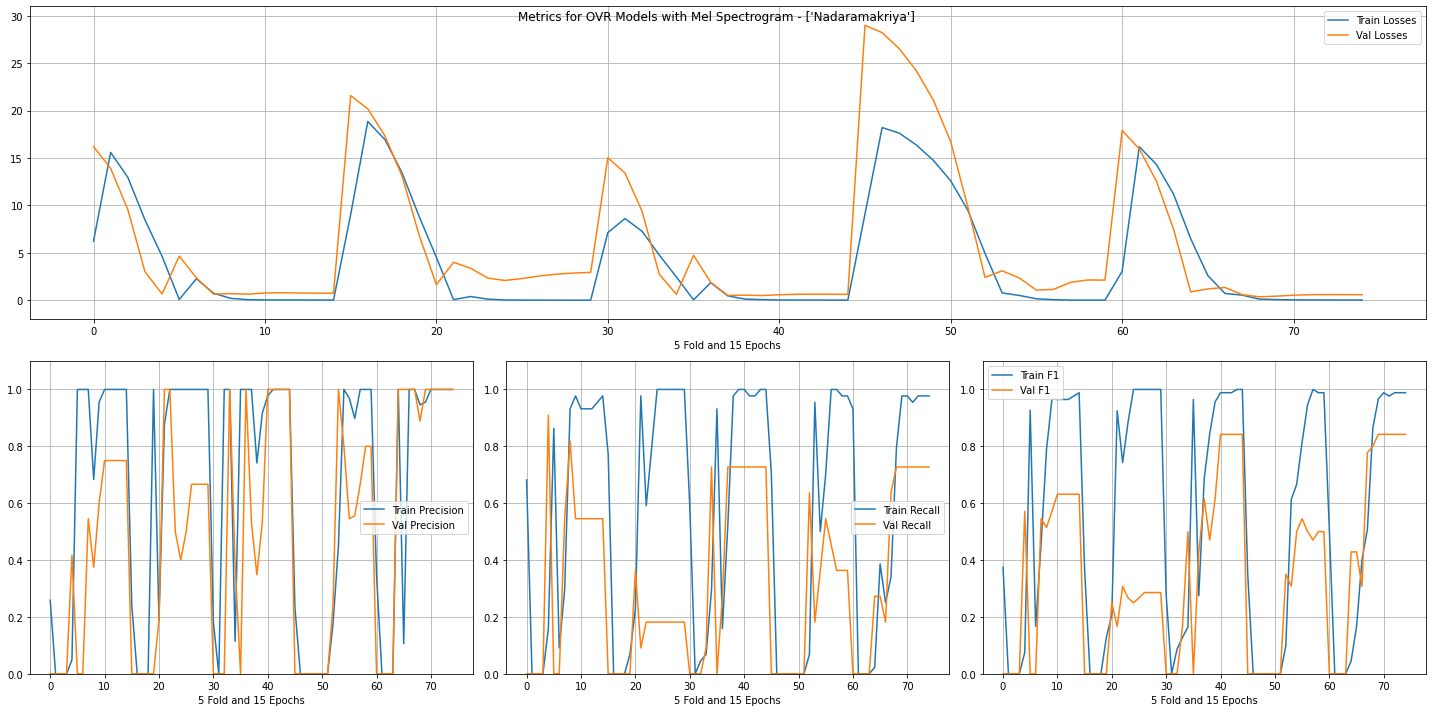

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.842105  ...      0.017695           0.628906
14  1.000000       0.842105  ...      0.015542           0.622456
10  0.988764       0.842105  ...      0.025555           0.579840
11  0.988506       0.842105  ...      0.021963           0.628133
12  0.988506       0.842105  ...      0.021953           0.634446
..       ...            ...  ...           ...                ...
5   0.000000       0.000000  ...     12.597391          16.710198
6   0.000000       0.000000  ...      9.489816           9.848627
1   0.000000       0.000000  ...     16.196348          15.976911
2   0.000000       0.000000  ...     14.325570          12.549847
3   0.000000       0.000000  ...     11.184080           7.485711

[75 rows x 12 columns]
Training for ['Paadi'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 292/74
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.246 / Validation Loss : 18.462 [Time 

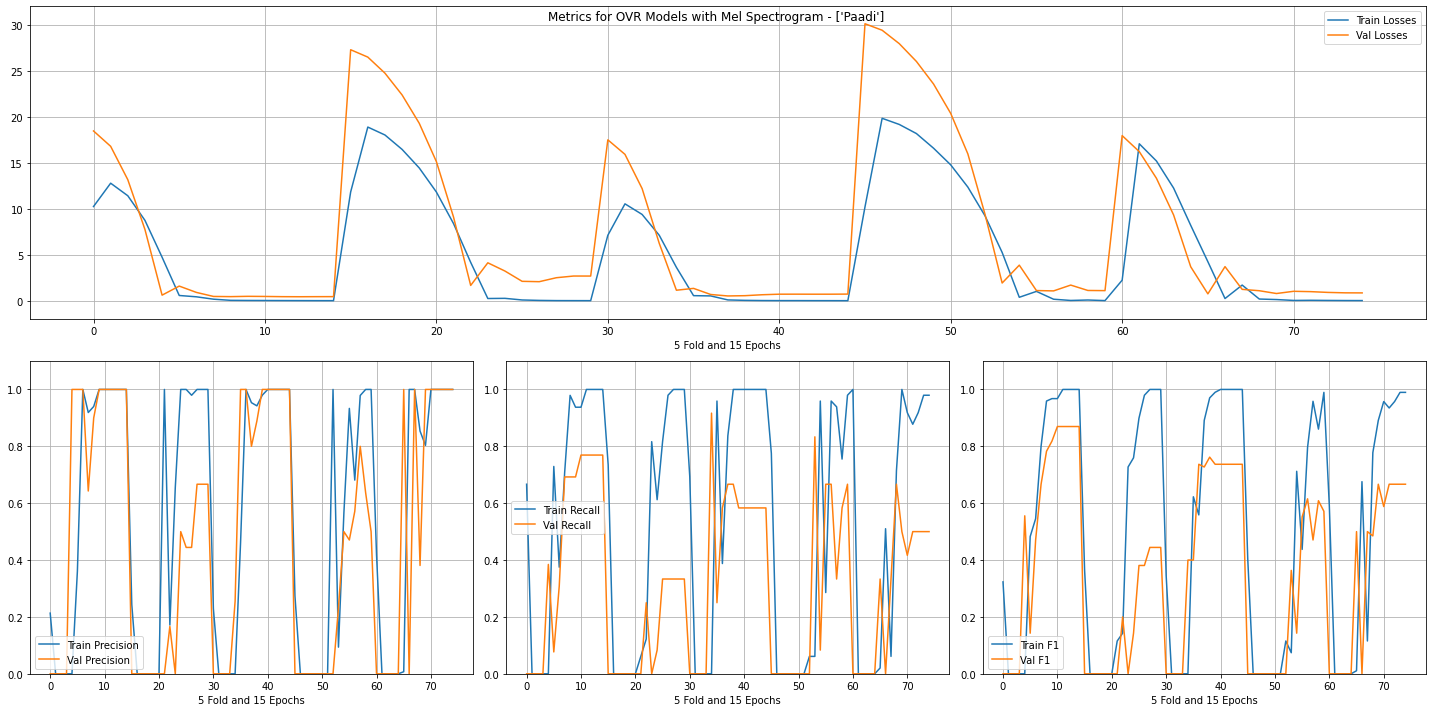

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.869565  ...      0.025872           0.449546
12  1.000000       0.869565  ...      0.021002           0.441841
13  1.000000       0.869565  ...      0.017162           0.449578
14  1.000000       0.869565  ...      0.015993           0.452916
10  0.967742       0.869565  ...      0.031559           0.472890
..       ...            ...  ...           ...                ...
6   0.000000       0.000000  ...     12.359518          15.968171
1   0.000000       0.000000  ...     17.065053          16.213393
2   0.000000       0.000000  ...     15.195629          13.317240
3   0.000000       0.000000  ...     12.256677           9.334480
4   0.000000       0.000000  ...      8.199415           3.696431

[75 rows x 12 columns]
Training for ['Ramakriya'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 470/118
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.850 / Validation Loss : 18.534 [T

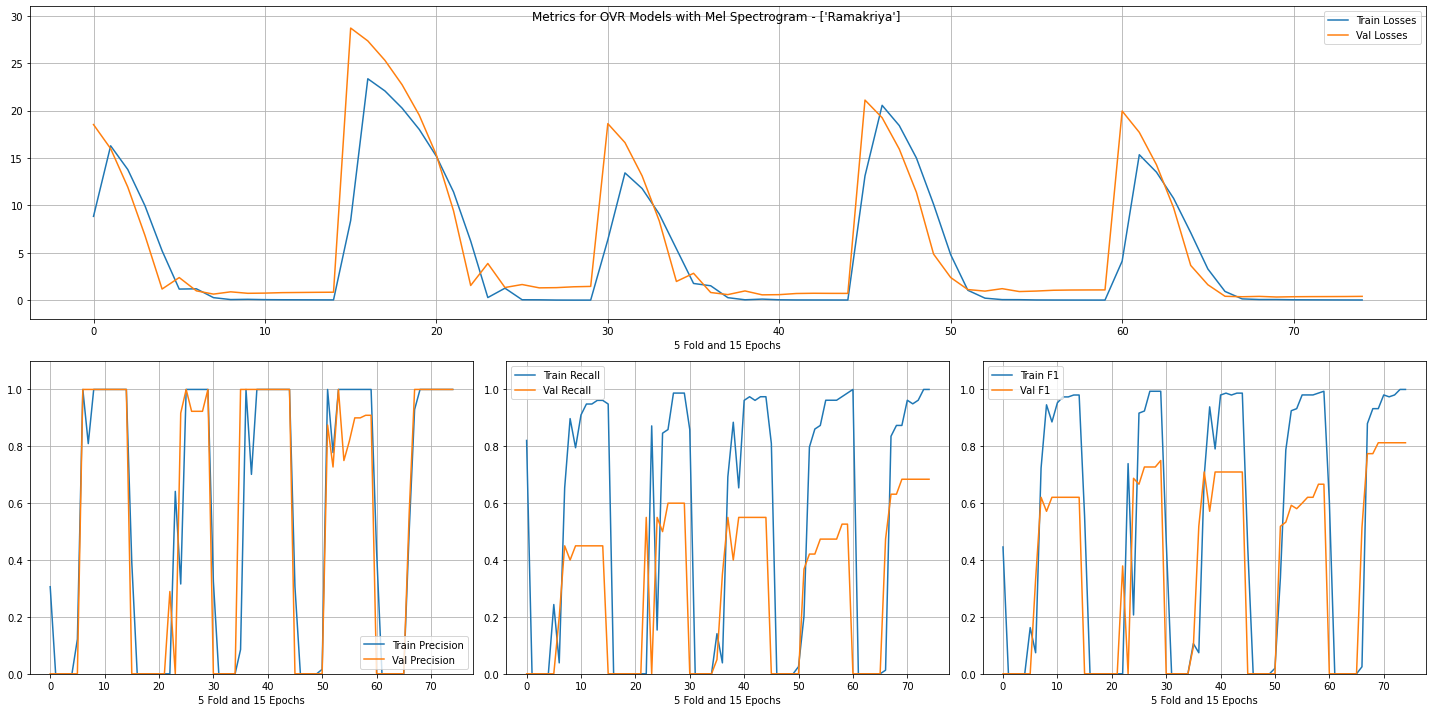

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000         0.8125  ...      0.032371           0.392780
14  1.000000         0.8125  ...      0.027278           0.408450
10  0.980645         0.8125  ...      0.050204           0.370848
12  0.980645         0.8125  ...      0.037388           0.386363
11  0.974026         0.8125  ...      0.043639           0.382021
..       ...            ...  ...           ...                ...
1   0.000000         0.0000  ...     15.351227          17.715405
2   0.000000         0.0000  ...     13.515292          14.302281
3   0.000000         0.0000  ...     10.749125           9.762332
4   0.000000         0.0000  ...      7.127279           3.671341
5   0.000000         0.0000  ...      3.298054           1.635341

[75 rows x 12 columns]
Training for ['Salangam'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 105/27
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 13.611 / Validation Loss : 3.791 [Tim

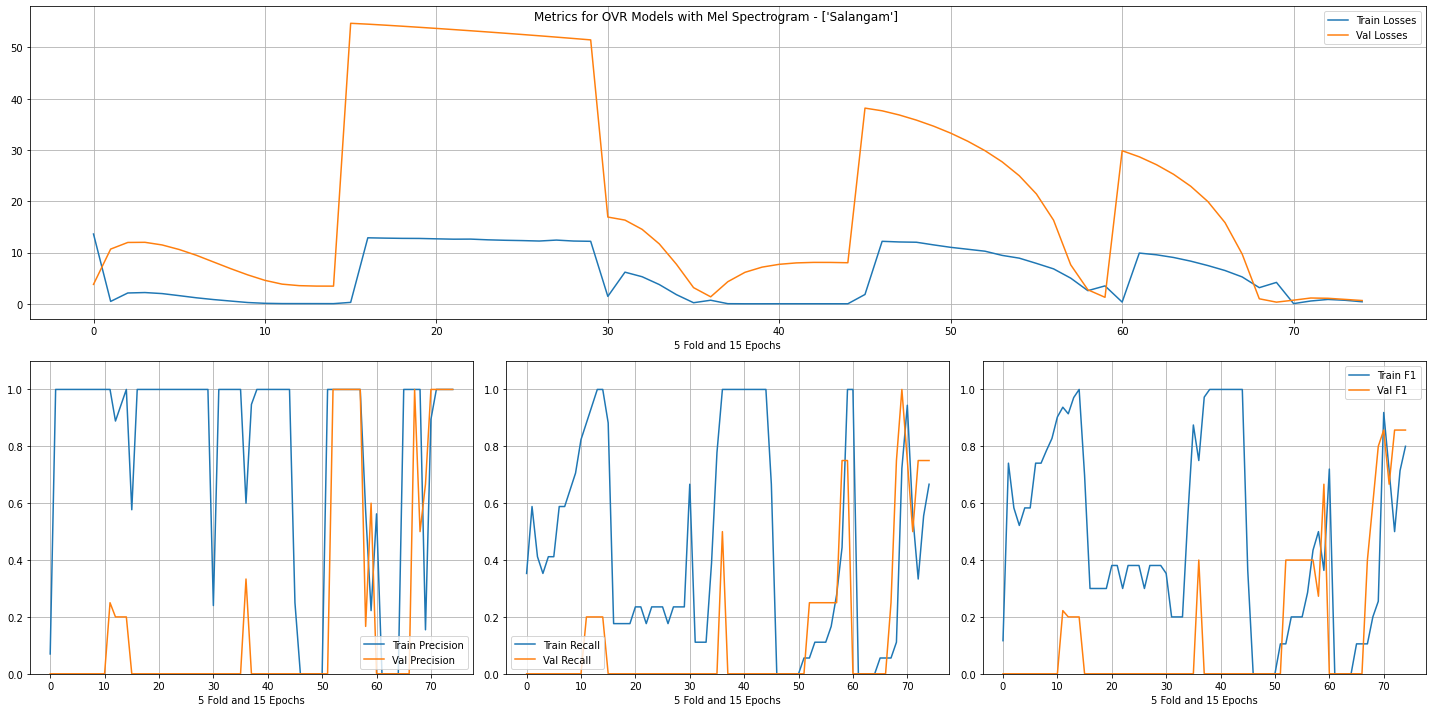

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.918919       0.857143  ...      0.040656           0.711354
14  0.800000       0.857143  ...      0.395702           0.641081
13  0.714286       0.857143  ...      0.690342           0.862528
12  0.500000       0.857143  ...      0.851839           1.080102
9   0.254902       0.800000  ...      4.175236           0.326602
..       ...            ...  ...           ...                ...
5   0.000000       0.000000  ...     11.015150          33.281082
1   0.000000       0.000000  ...      9.894760          28.664577
2   0.000000       0.000000  ...      9.560706          27.133947
3   0.000000       0.000000  ...      9.035905          25.255850
4   0.000000       0.000000  ...      8.320881          22.925720

[75 rows x 12 columns]
Training for ['Salanganata'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 326/82
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.173 / Validation Loss : 17.253 [

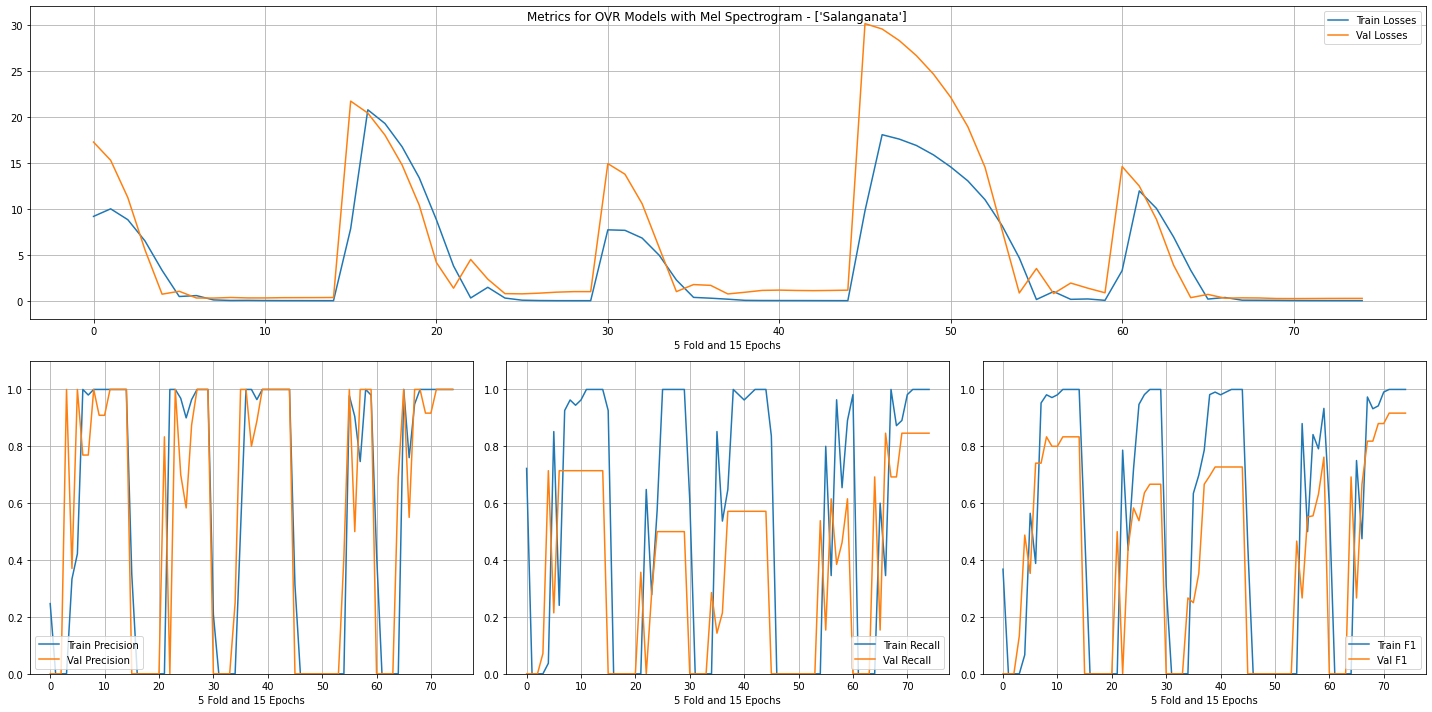

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.916667  ...      0.027905           0.247432
12  1.000000       0.916667  ...      0.024029           0.257199
13  1.000000       0.916667  ...      0.021788           0.260977
14  1.000000       0.916667  ...      0.020031           0.260553
10  0.990826       0.880000  ...      0.034892           0.240990
..       ...            ...  ...           ...                ...
7   0.000000       0.000000  ...     10.993636          14.519164
8   0.000000       0.000000  ...      8.157280           7.646100
1   0.000000       0.000000  ...     11.948893          12.474753
2   0.000000       0.000000  ...     10.043649           8.851518
3   0.000000       0.000000  ...      6.937139           3.876661

[75 rows x 12 columns]
Training for ['Samantham'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 158/40
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.539 / Validation Loss : 9.368 [Ti

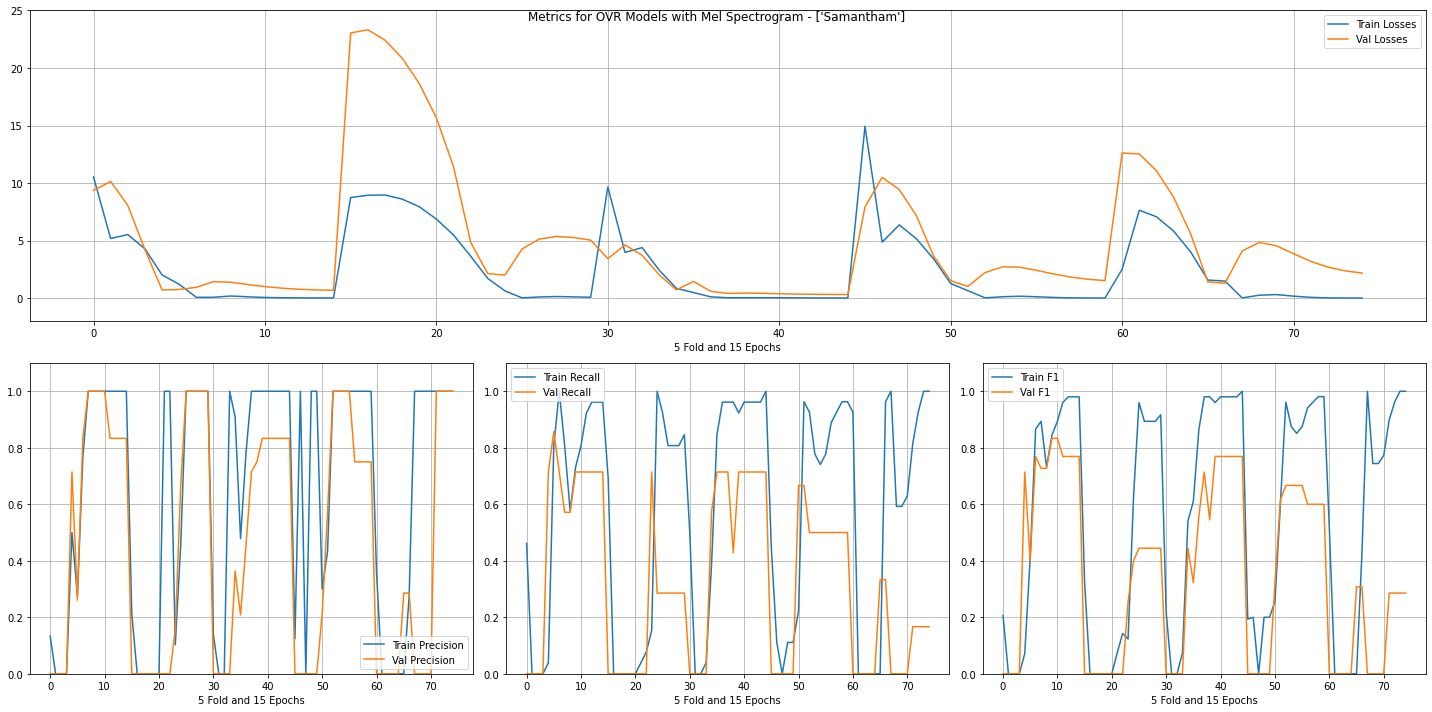

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.893617       0.833333  ...      0.061367           1.006577
9   0.844444       0.833333  ...      0.120179           1.184865
14  1.000000       0.769231  ...      0.013763           0.319246
12  0.980392       0.769231  ...      0.024802           0.774440
13  0.980392       0.769231  ...      0.019086           0.716893
..       ...            ...  ...           ...                ...
2   0.000000       0.000000  ...      6.365209           9.429669
1   0.000000       0.000000  ...      7.642467          12.527145
2   0.000000       0.000000  ...      7.073128          11.069527
3   0.000000       0.000000  ...      5.832109           8.777107
4   0.000000       0.000000  ...      4.011229           5.567363

[75 rows x 12 columns]
Training for ['Sankarabharanam'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 312/78
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.390 / Validation Loss : 15.

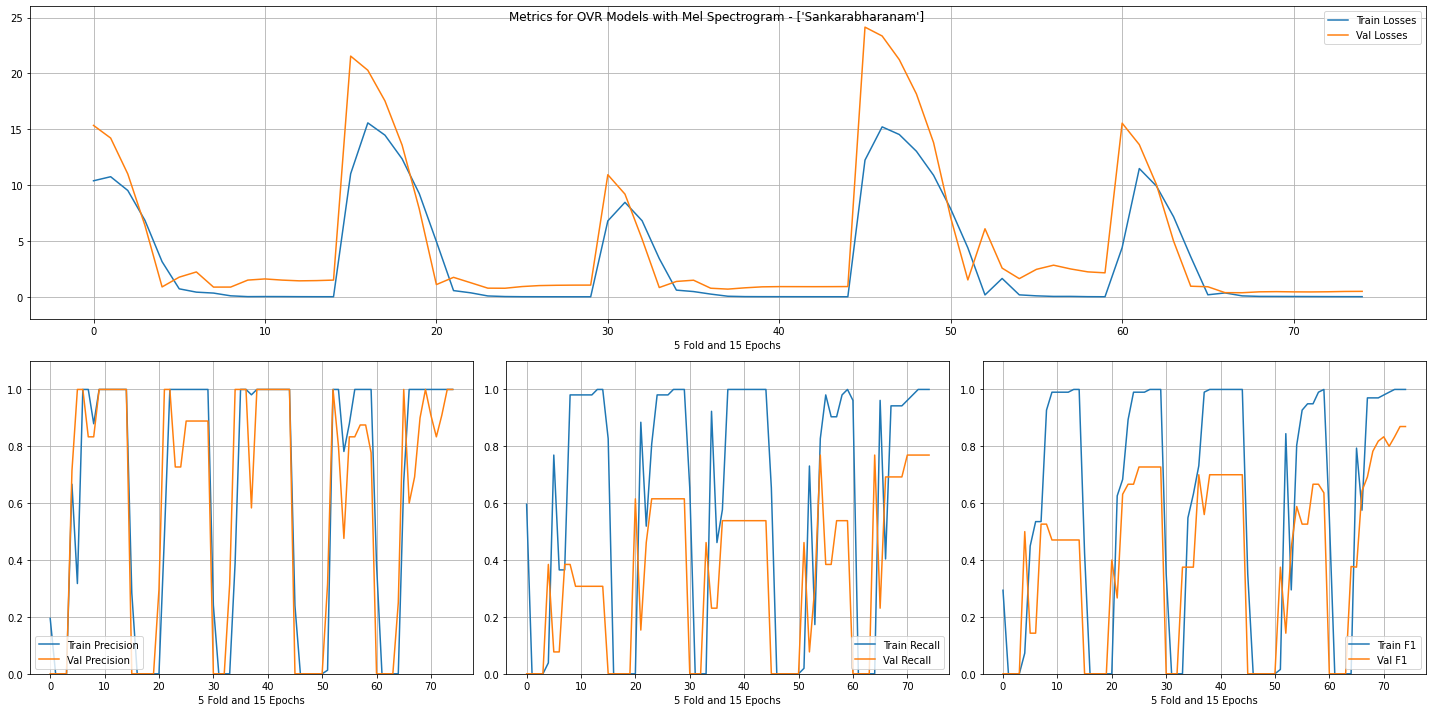

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.869565  ...      0.019153           0.483293
14  1.000000       0.869565  ...      0.017567           0.492435
12  1.000000       0.833333  ...      0.022646           0.454628
10  0.980392       0.833333  ...      0.032642           0.446750
9   0.970297       0.818182  ...      0.037685           0.466198
..       ...            ...  ...           ...                ...
4   0.000000       0.000000  ...     10.881523          13.805708
5   0.000000       0.000000  ...      7.871343           7.092969
1   0.000000       0.000000  ...     11.486779          13.629784
2   0.000000       0.000000  ...      9.916795          10.051156
3   0.000000       0.000000  ...      7.168052           4.989884

[75 rows x 12 columns]
Training for ['Sriragam'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 427/107
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 8.285 / Validation Loss : 14.781 [Ti

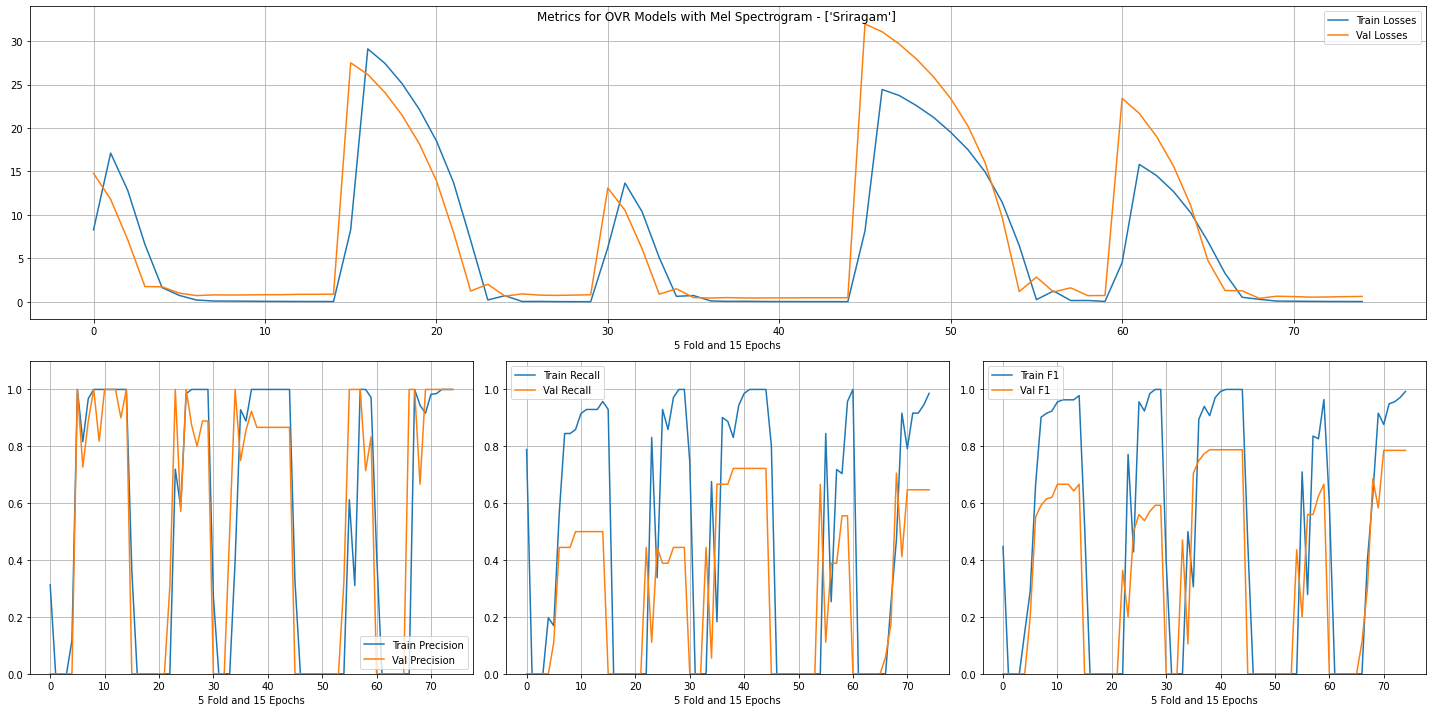

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.787879  ...      0.028583           0.458654
12  1.000000       0.787879  ...      0.025080           0.464215
13  1.000000       0.787879  ...      0.023695           0.467066
14  1.000000       0.787879  ...      0.019986           0.476280
10  0.992908       0.787879  ...      0.032852           0.451494
..       ...            ...  ...           ...                ...
1   0.000000       0.000000  ...     15.819134          21.687151
2   0.000000       0.000000  ...     14.540425          19.047761
3   0.000000       0.000000  ...     12.688318          15.606403
4   0.000000       0.000000  ...     10.245454          11.079924
5   0.000000       0.000000  ...      6.949785           4.755926

[75 rows x 12 columns]
Training for ['Suddavasantham'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 6.131 / Validation Loss : 1.275 

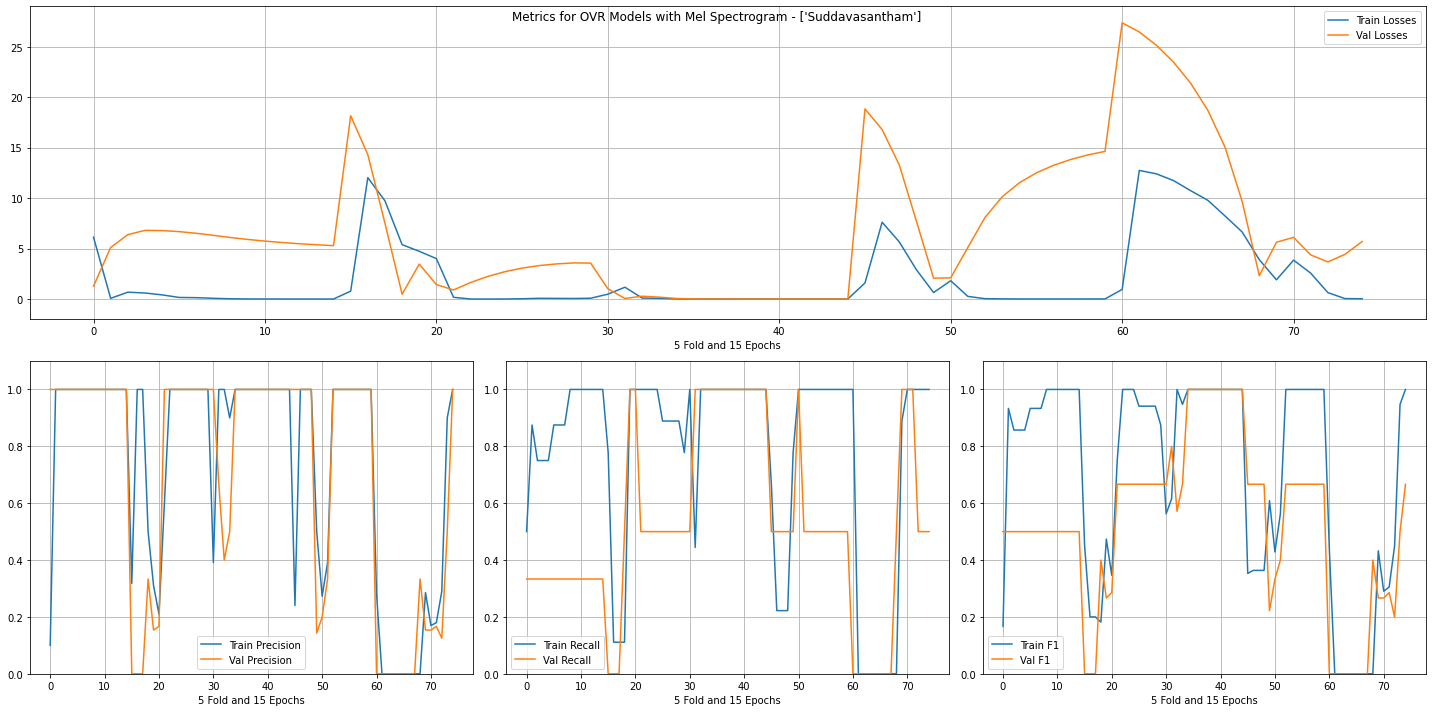

    train_f1  validation_f1  ...  train_losses  validation_losses
4        1.0            1.0  ...      0.014588           0.055388
5        1.0            1.0  ...      0.004616           0.014312
6        1.0            1.0  ...      0.002422           0.004804
7        1.0            1.0  ...      0.001478           0.002043
8        1.0            1.0  ...      0.000969           0.001036
..       ...            ...  ...           ...                ...
3        0.0            0.0  ...     11.733651          23.471952
4        0.0            0.0  ...     10.732940          21.380426
5        0.0            0.0  ...      9.781736          18.691051
6        0.0            0.0  ...      8.232370          15.055134
7        0.0            0.0  ...      6.644555           9.671853

[75 rows x 12 columns]
Training for ['Varali'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 451/113
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 9.866 / Validation Loss : 20.066 [Time

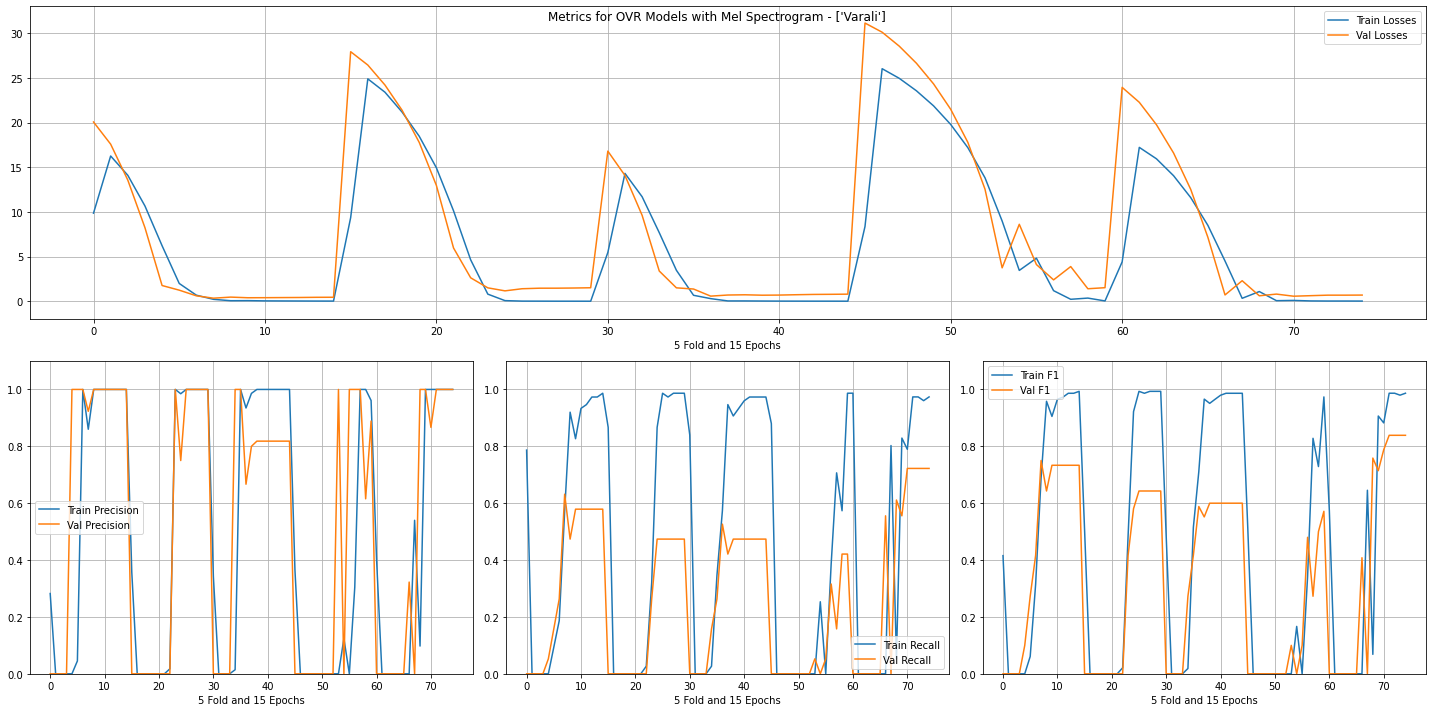

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.986667       0.838710  ...      0.043539           0.632758
12  0.986667       0.838710  ...      0.032583           0.690067
14  0.986667       0.838710  ...      0.028369           0.699692
13  0.979866       0.838710  ...      0.033099           0.689609
10  0.882353       0.787879  ...      0.100663           0.572573
..       ...            ...  ...           ...                ...
1   0.000000       0.000000  ...     17.226223          22.268719
2   0.000000       0.000000  ...     15.949091          19.764429
3   0.000000       0.000000  ...     14.054594          16.592840
4   0.000000       0.000000  ...     11.604968          12.524576
5   0.000000       0.000000  ...      8.504781           7.167558

[75 rows x 12 columns]


In [14]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MelMatrixDataset, MelRaga, "OVR Models with Mel Spectrogram", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-5, epochs=15, n_folds=5, feature='mel_spec',nindex_factor=5)

In [17]:
tab = pd.DataFrame(columns=['Raga','Train Confusion','Test Confusion'] + list(ovr_res[list(ovr_res.keys())[0]][1].keys()))
idx = 0
nresults = 1
for r in ovr_res:
  # Get top "nresults"
  tmp = results_to_df(ovr_res[r]).head(nresults)
  for _ in range(nresults):
    tab.loc[idx,'Raga'] = le.inverse_transform([r])[0]
    for i in tmp.columns:
      tab.loc[idx,i] = tmp[i].tolist()[_]
    t = confusion_matrix(tab.loc[idx,'train_labels'][0],tab.loc[idx,'train_predictions'][0])
    tab.loc[idx,'Train Confusion'] = str(t[0]) + '\n' +str(t[1])
    t = confusion_matrix(tab.loc[idx,'test_labels'][0],tab.loc[idx,'test_predictions'][0])
    tab.loc[idx,'Test Confusion'] = str(t[0]) + '\n' +str(t[1])
    idx = idx + 1

In [18]:
from IPython.display import display, HTML
display( HTML( tab[['Raga','Train Confusion','Test Confusion','train_f1','validation_f1','train_precision','validation_precision','train_recall','validation_recall']].to_html().replace("\\n","<br>") ) )

In [32]:
tab.index = tab['Raga']

In [41]:
def bar_plot(df, cols, title):
  df[cols].plot.bar(figsize=[20,5],grid=True)
  plt.title(title)
  plt.legend(['Train','Validation'])
  plt.xticks(rotation=45)
  plt.show()

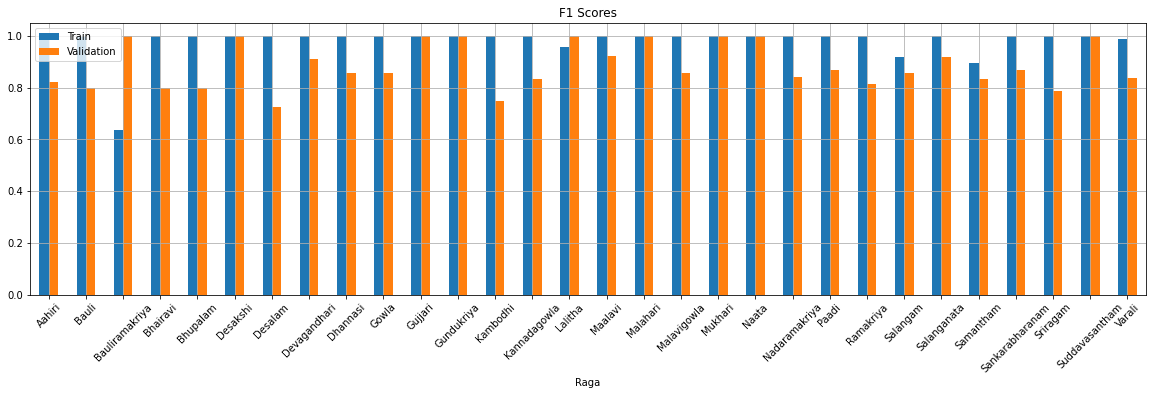

In [42]:
bar_plot(tab, ['train_f1','validation_f1'],'F1 Scores')

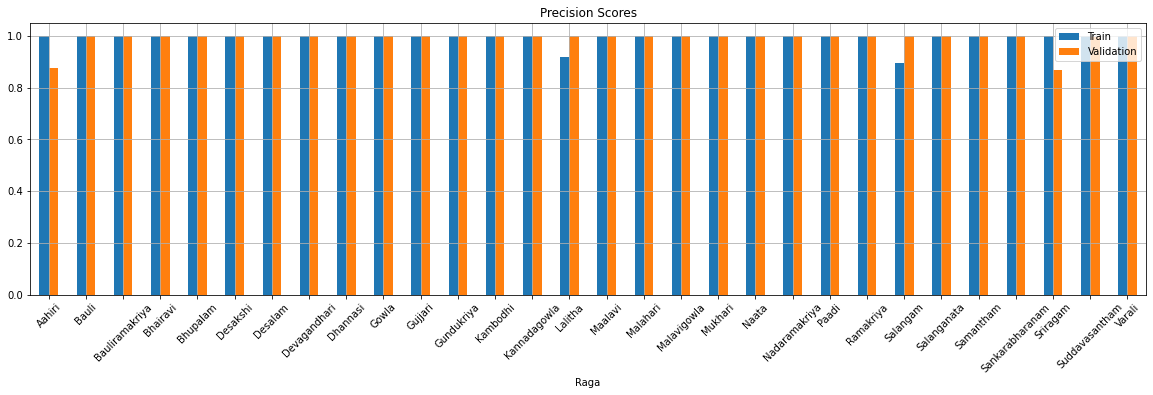

In [43]:
bar_plot(tab, ['train_precision','validation_precision'],'Precision Scores')

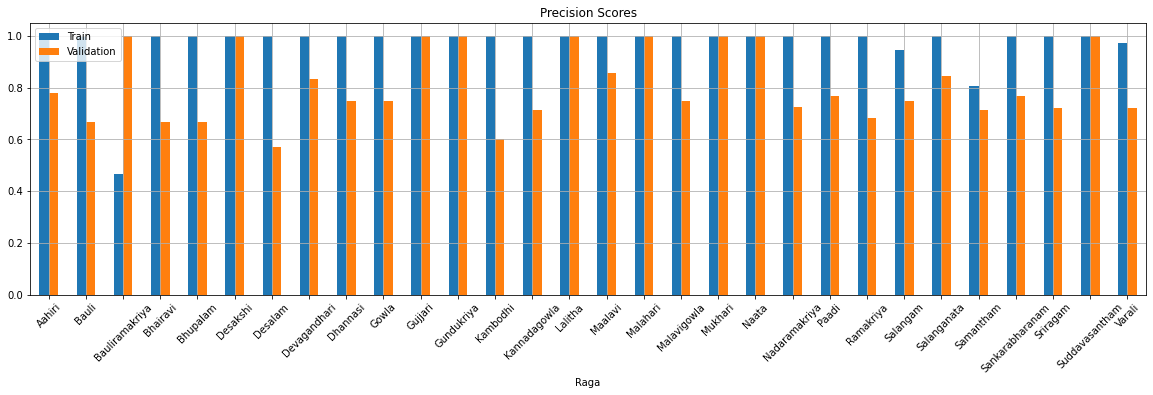

In [44]:
bar_plot(tab, ['train_recall','validation_recall'],'Precision Scores')